**Eric Young**  
**Data Science**  
**Final Project**  
**Predicting Box Office Results and Movie Sentiment Using Supervised Learning Methods**    
**3/2/16**  

This project explores the use of supervised learning methods to predict Box Office results and movie sentiment based on a defined feature space of attributes obtained from three data sources – Box Office Mojo, The Open Movie Database (OMDb), and Rotten Tomatoes. Specifically, there are three predictions presented below in the code:  
1. Predicting Box Office Results Based on Select Movie Attributes, Ratings, and Reviews Using OLS Linear Regression  
2. Predicting Movie Sentiment Based on Box Office Results and Select Movie Attributes Using Logistic Regression, Naive Bayes, KNN, Random Forest, and SVM Classifiers  
3. Predicting Movie Sentiment Based on Plot Summary Using Random Forest and Naive Bayes Classifiers  

Note: The code in this notebook has been executed to save time, as the OMDb data file is over 400MBs. Output may not match findings presented in accompanying presentation or paper.  


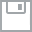
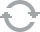
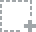
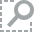
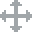
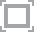
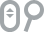
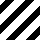
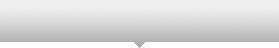
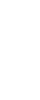
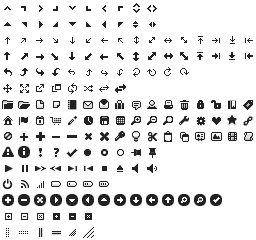
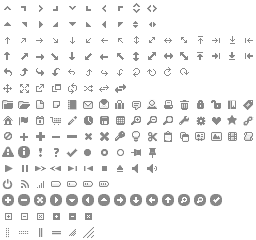
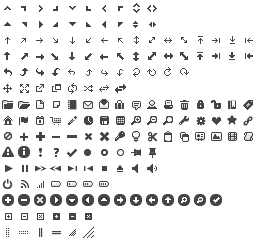
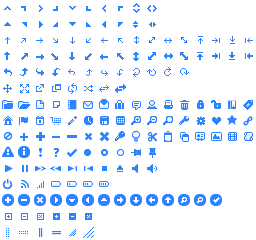
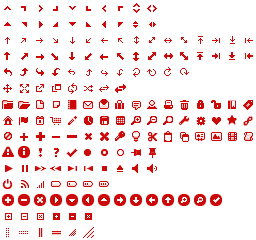
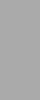
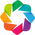
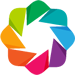

In [1]:
# import all libraries
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import FixedTicker
from bokeh.models import Range1d
from bokeh.models import NumeralTickFormatter
output_notebook()

%matplotlib inline

### 0. Pre-Processing Steps

###### Loading and pre-processing of Box Office data

In [2]:
# read in box office results from csv file
# remove "/import.io" from read_csv if loading from current directory
box = pd.read_csv('./import.io/box_office_results_121515_cleaned.csv', delimiter=',', error_bad_lines = False)

In [3]:
# rename columns
box.rename(columns = {'_num':'list_number', 'title/_text':'btitle', 'opening_date/_text':'opening_date'}, inplace = True)

# replace n/a values with null values
box.total_theatres.replace(['None'], [np.nan], inplace = True)

# replace non-numeric values with null values
box.total_gross.replace(['Total Gross / Theaters', 'n/a', 'n/a*'], [np.nan, np.nan, np.nan], inplace = True)

# replace dollar signs, asterisks, commas, and spaces and converts data into float 
box.total_gross = box.total_gross.str.replace('$','').str.replace('*', '').str.replace(',', '').str.replace(' ', '')
box.total_gross = box.total_gross.convert_objects(convert_numeric=True)

# convert total theatres to numeric
box.total_theatres = box.total_theatres.convert_objects(convert_numeric=True)

# replace non-numeric values with null values
box.opening_gross.replace(['Opening / Theaters', 'n/a'], [np.nan, np.nan], inplace = True)

# replace dollar signs, asterisks, commas, and spaces and converts data into numeric 
box.opening_gross = box.opening_gross.str.replace('$','').str.replace('*', '').str.replace(',', '').str.replace(' ', '')
box.opening_gross = box.opening_gross.convert_objects(convert_numeric=True)

# replace n/a values with null values
box.opening_theatres.replace(['n/a'], [np.nan], inplace = True)

# replace dollar signs, asterisks, commas, and spaces and converts data into numeric 
box.opening_theatres = box.opening_theatres.str.replace('$','').str.replace('*', '').str.replace(',', '').str.replace(' ', '')
box.opening_theatres = box.opening_theatres.convert_objects(convert_numeric=True)

# replace non-conforming date formats with null values
box.opening_date.replace(['TBD', 'Winter 2015', '2015', '2016', '2017', '2018', '2020'], [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan], inplace = True)

# format opening date string into datetime format
box['opening_date'] = pd.to_datetime(box['opening_date'], format = "%m/%d/%Y")

# replace '&' in title with 'and' and string columns with UTF equivalents
box.btitle = box.btitle.str.replace('&', 'and')
box.btitle = box.btitle.str.decode('latin-1')
box.btitle = box.btitle.str.encode('utf-8')

# standardize string columns by making lower case
box.btitle = box.btitle.str.lower()
box.studio = box.studio.str.lower()

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:29: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [4]:
# extract year from opening_date, convert into string and combine with title to create title_year column
box['byear'] = box['opening_date'].dt.year
box['byear'] = box.byear.astype(str)
box['byear'] = box.byear.str.split('.').str[0]
box['title_year'] = box['btitle'] + '_' + box['byear']

# filter box office results for period from 2000 to 2015
box = box[(box.byear >= '2000') & (box.byear <= '2015')]

###### Loading and pre-processing of OMDb data

In [5]:
# read in the omdb csv file
omdb = pd.read_csv('./omdbMovies.txt', delimiter='\t', error_bad_lines = False, dtype = object)

Skipping line 193827: expected 21 fields, saw 27

Skipping line 369640: expected 21 fields, saw 22

Skipping line 521337: expected 21 fields, saw 22

Skipping line 611109: expected 21 fields, saw 22

Skipping line 675690: expected 21 fields, saw 22

Skipping line 746112: expected 21 fields, saw 22

Skipping line 757554: expected 21 fields, saw 22

Skipping line 1064760: expected 21 fields, saw 22



In [6]:
# convert year column to numeric
omdb.Year = omdb.Year.convert_objects(convert_numeric=True)

# rename omdb columns and make headers all lowercase
omdb.rename(columns = {'Title':'otitle', 'Year':'oyear', 'Plot':'plots'}, inplace = True)
omdb.columns = map(str.lower, omdb.columns)

# replace '&' with 'and' and replace string columns with UTF equivalents
omdb.otitle = omdb.otitle.str.replace('&', 'and')
omdb.otitle = omdb.otitle.str.decode('latin-1')
omdb.otitle = omdb.otitle.str.encode('utf-8')
omdb.director = omdb.director.str.decode('latin-1')
omdb.director = omdb.director.str.encode('utf-8')
omdb.writer = omdb.writer.str.replace('(', '|')
omdb.writer = omdb.writer.str.replace(')', '|')
omdb.writer = omdb.writer.str.decode('latin-1')
omdb.writer = omdb.writer.str.encode('utf-8')
omdb.cast = omdb.cast.str.decode('latin-1')
omdb.cast = omdb.cast.str.encode('utf-8')
omdb.plots = omdb.plots.str.decode('latin-1')
omdb.plots = omdb.plots.str.encode('utf-8')

# make all string columns lowercase
omdb.otitle = omdb.otitle.str.lower()
omdb.rating = omdb.rating.str.lower()
omdb.genre = omdb.genre.str.lower()
omdb.director = omdb.director.str.lower()
omdb.writer = omdb.writer.str.lower()
omdb.cast = omdb.cast.str.lower()
omdb.plots = omdb.plots.str.lower()
omdb.language = omdb.language.str.lower()
omdb.country = omdb.country.str.lower()
omdb.awards = omdb.awards.str.lower()

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [7]:
# convert omdb year into string and combine with title to create title_year column
omdb['oyear'] = omdb.oyear.astype(str)
omdb['oyear'] = omdb.oyear.str.split('.').str[0]
omdb['title_year'] = omdb['otitle'] + '_' + omdb['oyear']

# filter omdb results for period from 1980 to 2015
omdb = omdb[(omdb.oyear >= '1980') & (omdb.oyear <= '2015')]

###### Merging of Box Office and OMDb data

In [8]:
# merge box and omdb dataframes
box_omdb = pd.merge(box, omdb, on = 'title_year', how = 'inner')

###### Loading and pre-processing of Rotten Tomatoes data

In [9]:
# read in the tomatoes file
tomatoes = pd.read_csv('./tomatoes.txt', delimiter='\t', error_bad_lines = False)

In [10]:
# rename columns, make production column lowercase, and convert omdb id to numeric in order to merge omdb and tomatoes dataframes
tomatoes.columns = map(str.lower, tomatoes.columns)
tomatoes.rename(columns = {'lastupdated':'tlastupdated', 'rating':'trating'}, inplace = True)
tomatoes.production = tomatoes.production.str.lower()
omdb.id = omdb.id.convert_objects(convert_numeric=True)

# filter out null values for tomatoes ratings
tomatoes = tomatoes[tomatoes.image.notnull()]

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


###### Merging of OMDb and Rotten Tomatoes data used to predict movie sentiment based on plot summary (Prediction 3) 

In [11]:
# merge omdb and tomatoes dataframes and filter results for period from 2000 to 2015 
omdb_tomatoes = pd.merge(omdb, tomatoes, on = 'id', how = 'inner')
omdb_tomatoes = omdb_tomatoes[(omdb_tomatoes.oyear >= '2000') & (omdb_tomatoes.oyear <= '2015')]

###### Merging of Box Office, OMDb, and Rotten Tomatoes data (bot) used to predict Box Office results and movie sentiment based on Box Office results and select movie attributes (Predictions 1 and 2)

In [12]:
# convert box_omdb id to numeric and merge box, omdb, and tomatoes dataframes on id
box_omdb.id = box_omdb.id.convert_objects(convert_numeric=True)
bot = pd.merge(box_omdb, tomatoes, on = 'id', how = 'inner')

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


###### Constructing feature space from dataset (bot) to create two datasets - one for Prediction 1 (bot_lnr) and one for Prediction 2 (bot_lor)

In [13]:
# filter bot column to be used for box office results linear regression
bot_lnr = bot[bot.columns[[13, 12, 7, 3, 4, 15, 21, 22, 23, 32, 33, 34, 35, 36, 38, 39, 40]]]

# filter bot column to be used for rotten or fresh logistic regression
bot_lor = bot[bot.columns[[13, 12, 7, 3, 14, 15, 16, 18, 20, 31]]]

###### Pre-processing of bot_lnr and bot_lor datasets

In [14]:
# filter out null values for total_gross and total_theatres in bot_lnr dataframe
bot_lnr = bot_lnr[(bot_lnr.total_gross.notnull())&(bot_lnr.total_theatres.notnull())]

# convert runtime string to numeric and impute null values
temp = bot_lnr.runtime.str.split(' ').str[0]
bot_lnr.runtime = temp.convert_objects(convert_numeric=True)
bot_lnr.runtime[bot_lnr.runtime.notnull()].describe()
bot_lnr.runtime.fillna(np.random.normal(104, 19), inplace=True)

# convert metacritic string to numeric and impute null values
bot_lnr.metacritic = bot_lnr.metacritic.convert_objects(convert_numeric=True)
bot_lnr.metacritic[bot_lnr.metacritic.notnull()].describe()
bot_lnr.metacritic.fillna(np.random.normal(53.7, 17.7), inplace=True)

# convert imdbrating string to numeric and impute null values
bot_lnr.imdbrating = bot_lnr.imdbrating.convert_objects(convert_numeric=True)
bot_lnr.imdbrating[bot_lnr.imdbrating.notnull()].describe()
bot_lnr.imdbrating.fillna(np.random.normal(6.4, 1.0), inplace=True)

# convert imdbvotes string to numeric and impute null values
bot_lnr.imdbvotes = bot_lnr.imdbvotes.convert_objects(convert_numeric=True)
bot_lnr.imdbvotes[bot_lnr.imdbvotes.notnull()].describe()
bot_lnr.imdbvotes.fillna(np.random.normal(65962, 113914), inplace=True)

# impute null values for usermeter
bot_lnr.usermeter[bot_lnr.usermeter.notnull()].describe()
bot_lnr.usermeter.fillna(np.random.normal(60.1, 18.9), inplace=True)

# impute null values for userrating
bot_lnr.userrating[bot_lnr.userrating.notnull()].describe()
bot_lnr.userrating.fillna(np.random.normal(3.3, 0.5), inplace=True)

# impute null values for userreviews
bot_lnr.userreviews[bot_lnr.userreviews.notnull()].describe()
bot_lnr.userreviews.fillna(np.random.normal(448688.4, 3206534.9), inplace=True)

# filter bot_lor results for 2015 movies to be used for out-of-sample testing
bot_lnr_oos = bot_lnr[(bot_lnr.oyear == '2015') & (bot_lnr.opening_date.dt.month <= 12)]

# filter bot_lnr results for period from 2000 to 2014 to be used for training and testing
bot_lnr = bot_lnr[(bot_lnr.oyear >= '2000') & (bot_lnr.oyear <= '2014')]

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [15]:
# filter out null values for total_gross, rating, genre, director, cast and image in bot_lor dataframe
bot_lor = bot_lor[(bot_lor.total_gross.notnull()) & (bot_lor.rating.notnull()) & (bot_lor.genre.notnull()) & (bot_lor.director.notnull()) & (bot_lor.cast.notnull())]

# map numbers to ratings
temp = bot_lor[(bot_lor.rating != 'tv-14') & (bot_lor.rating != 'tv-ma') & (bot_lor.rating != 'tv-g') & (bot_lor.rating != 'tv-pg') & (bot_lor.rating != 'ao')]
bot_lor.rating = temp.rating.map({'not rated':0, 'unrated':0, 'g':1, 'pg':2, 'pg-13':3, 'r':4, 'nc-17':5, 'x':6})

# convert runtime string to numeric and impute null values
temp = bot_lor.runtime.str.split(' ').str[0]
bot_lor.runtime = temp.convert_objects(convert_numeric=True)
bot_lor.runtime[bot_lor.runtime.notnull()].describe()
bot_lor.runtime.fillna(np.random.normal(104.7, 17.9), inplace=True)

# filter bot_lor results for period from 2000 to 2015
bot_lor = bot_lor[(bot_lor.oyear >= '2000') & (bot_lor.oyear <= '2015')]

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


### 1. Predicting Box Office Results Based on Select Movie Attributes, Ratings, and Reviews Using OLS Linear Regression

###### Visualizations exploring the relationships between dependent and independent variables

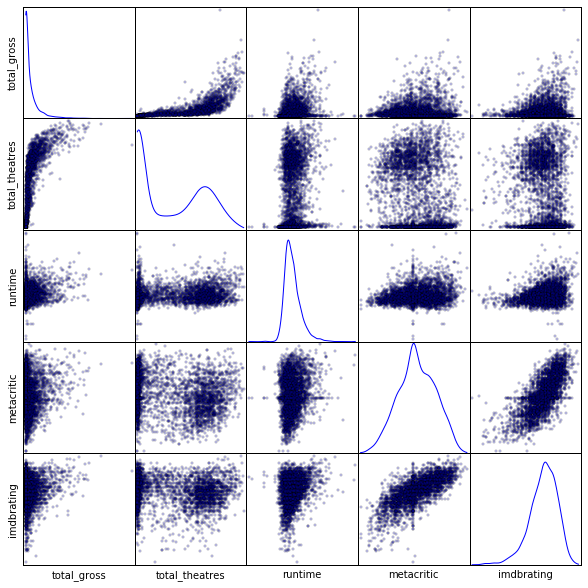

In [16]:
sm = scatter_matrix(bot_lnr[bot_lnr.columns[[3, 4, 5, 6, 7]]], alpha = 0.2, figsize = (10, 10), diagonal='kde')

# hide tick marks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

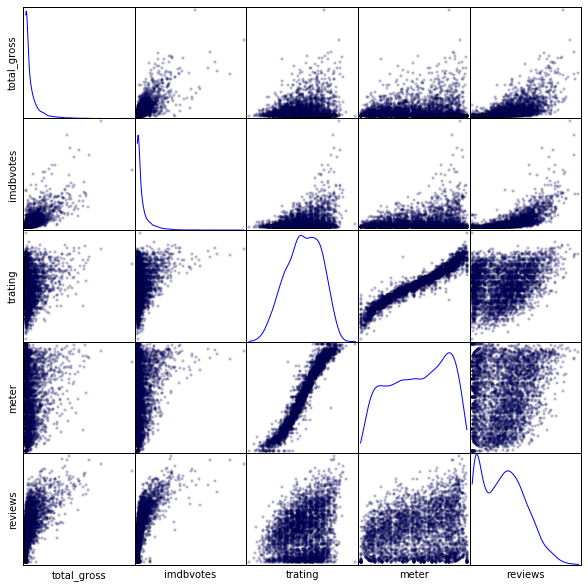

In [17]:
sm = scatter_matrix(bot_lnr[bot_lnr.columns[[3, 8, 9, 10, 11]]], alpha = 0.2, figsize = (10, 10), diagonal='kde')

# hide tick marks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

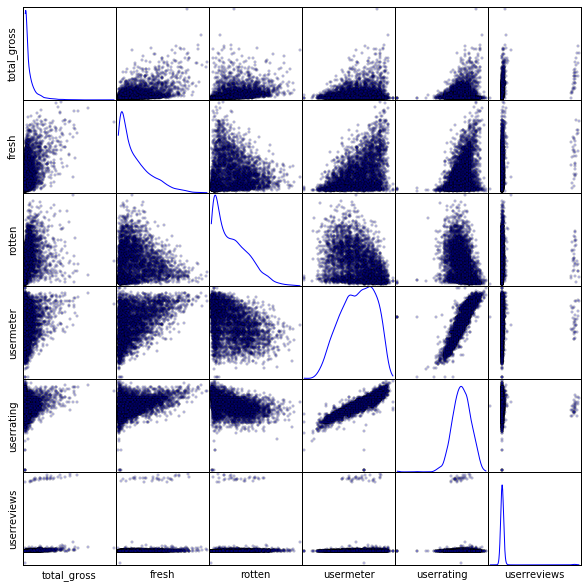

In [18]:
sm = scatter_matrix(bot_lnr[bot_lnr.columns[[3, 12, 13, 14, 15, 16]]], alpha = 0.2, figsize = (10, 10), diagonal='kde')

# hide tick marks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

###### Plots of three principal relationships identified by visualizations above

In [19]:
# show plots of different relationships between variables

# scatter plot of near linear relationship
p_total_theatres = figure(plot_width=475, plot_height=200)
p_total_theatres.circle(bot_lnr.total_theatres.values, bot_lnr.total_gross.values, size=3, color="#001C5C", alpha=0.5)

p_total_theatres.xaxis.axis_line_color = 'Black'
p_total_theatres.yaxis.axis_line_color = 'Black'
p_total_theatres.xaxis.major_label_text_color = 'Black'
p_total_theatres.yaxis.major_label_text_color = 'Black'
p_total_theatres.xaxis.major_label_text_font_size = '11pt'
p_total_theatres.yaxis.major_label_text_font_size = '11pt'
p_total_theatres.x_range=Range1d(0, 5000)
p_total_theatres.y_range=Range1d(0, 800000000)
p_total_theatres.xaxis[0].ticker=FixedTicker(ticks=[0, 1000, 2000, 3000, 4000, 5000])
p_total_theatres.yaxis[0].ticker=FixedTicker(ticks=[0, 200000000, 400000000, 600000000, 800000000])
p_total_theatres.xaxis[0].formatter = NumeralTickFormatter(format="0")
p_total_theatres.yaxis[0].formatter = NumeralTickFormatter(format="$0a")
p_total_theatres.xgrid.grid_line_color = None
p_total_theatres.ygrid.grid_line_color = None
p_total_theatres.xaxis.minor_tick_line_color = None
p_total_theatres.yaxis.minor_tick_line_color = None
p_total_theatres.background_fill = None
p_total_theatres.outline_line_color = None

show(p_total_theatres)

# scatter plot of no linear relationship
p_runtime = figure(plot_width=475, plot_height=200)
p_runtime.circle(bot_lnr.runtime.values, bot_lnr.total_gross.values, size=3, color="#001C5C", alpha=0.5)


p_runtime.xaxis.axis_line_color = 'Black'
p_runtime.yaxis.axis_line_color = 'Black'
p_runtime.xaxis.major_label_text_color = 'Black'
p_runtime.yaxis.major_label_text_color = 'Black'
p_runtime.xaxis.major_label_text_font_size = '11pt'
p_runtime.yaxis.major_label_text_font_size = '11pt'
p_runtime.x_range=Range1d(0, 250)
p_runtime.y_range=Range1d(0, 800000000)
p_runtime.xaxis[0].ticker=FixedTicker(ticks=[0, 50, 100, 150, 200, 250])
p_runtime.yaxis[0].ticker=FixedTicker(ticks=[0, 200000000, 400000000, 600000000, 800000000])
p_runtime.xaxis[0].formatter = NumeralTickFormatter(format="0")
p_runtime.yaxis[0].formatter = NumeralTickFormatter(format="$0a")
p_runtime.xgrid.grid_line_color = None
p_runtime.ygrid.grid_line_color = None
p_runtime.xaxis.minor_tick_line_color = None
p_runtime.yaxis.minor_tick_line_color = None
p_runtime.background_fill = None
p_runtime.outline_line_color = None

show(p_runtime)

# scatter plot of collinearity
p_usermeter = figure(plot_width=456, plot_height=200)
p_usermeter.circle(bot_lnr.usermeter.values, bot_lnr.userrating.values, size=3, color="#001C5C", alpha=0.5)

p_usermeter.xaxis.axis_line_color = 'Black'
p_usermeter.yaxis.axis_line_color = 'Black'
p_usermeter.xaxis.major_label_text_color = 'Black'
p_usermeter.yaxis.major_label_text_color = 'Black'
p_usermeter.xaxis.major_label_text_font_size = '11pt'
p_usermeter.yaxis.major_label_text_font_size = '11pt'
p_usermeter.x_range=Range1d(0, 100)
p_usermeter.y_range=Range1d(0, 5)
p_usermeter.xaxis[0].ticker=FixedTicker(ticks=[0, 20, 40, 60, 80, 100])
p_usermeter.yaxis[0].ticker=FixedTicker(ticks=[0, 1, 2, 3, 4, 5])
p_usermeter.xaxis[0].formatter = NumeralTickFormatter(format="0")
p_usermeter.yaxis[0].formatter = NumeralTickFormatter(format="0.0")
p_usermeter.xgrid.grid_line_color = None
p_usermeter.ygrid.grid_line_color = None
p_usermeter.xaxis.minor_tick_line_color = None
p_usermeter.yaxis.minor_tick_line_color = None
p_usermeter.background_fill = None
p_usermeter.outline_line_color = None

show(p_usermeter)

###### Segment dataset into three five-year time periods 2000 – 2004, 2005 – 2009, 2010 – 2014, and train and test each to make predictions

In [20]:
import statsmodels.api as sm

# filter movies by year for period 2000-2004, 2005-2009, 2010-2014
bot_lnr1 = bot_lnr[(bot_lnr.oyear >= '2000') & (bot_lnr.oyear <= '2004')]
bot_lnr2 = bot_lnr[(bot_lnr.oyear >= '2005') & (bot_lnr.oyear <= '2009')]
bot_lnr3 = bot_lnr[(bot_lnr.oyear >= '2010') & (bot_lnr.oyear <= '2014')]

# run linear regression for 2000-2004
x1 = bot_lnr1.drop(['oyear', 'otitle', 'opening_date', 'total_gross'], axis = 1)
y1 = bot_lnr1['total_gross']

# standardize features and target
scaler = StandardScaler()
scal_x1 = scaler.fit_transform(x1)
x1 = scal_x1

X1 = sm.add_constant(x1, prepend=True)

# train/test split, fit the model, and make predictions
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state=1)
results1 = sm.OLS(y1_train, X1_train).fit()
print results1.summary()
preds1 = results1.predict(X1_test)
print (preds1 - y1_test).mean()
print (preds1 - y1_test).mean() / y1_test.mean()

# run linear regression for 2005-2010
x2 = bot_lnr2.drop(['oyear', 'otitle', 'opening_date', 'total_gross'], axis = 1)
y2 = bot_lnr2['total_gross'].values

# standardize features and target
scaler = StandardScaler()
scal_x2 = scaler.fit_transform(x2)
x2 = scal_x2

X2 = sm.add_constant(x2, prepend=True)

# train/test split, fit the model, and make predictions
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state=1)
results2 = sm.OLS(y2_train, X2_train).fit()
print results2.summary()
preds2 = results2.predict(X2_test)
print (preds2 - y2_test).mean()
print (preds2 - y2_test).mean() / y2_test.mean()

# run linear regression for 2010-2014
x3 = bot_lnr3.drop(['oyear', 'otitle', 'opening_date', 'total_gross'], axis = 1)
y3 = bot_lnr3['total_gross'].values

# standardize features and target
scaler = StandardScaler()
scal_x3 = scaler.fit_transform(x3)
x3 = scal_x3

X3 = sm.add_constant(x3, prepend=True)

# train/test split, fit the model, and make predictions
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2, random_state=1)
results3 = sm.OLS(y3_train, X3_train).fit()
print results3.summary()
preds3 = results3.predict(X3_test)
print (preds3 - y3_test).mean()
print (preds3 - y3_test).mean() / y3_test.mean()

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     165.9
Date:                Tue, 01 Mar 2016   Prob (F-statistic):          1.12e-208
Time:                        00:19:00   Log-Likelihood:                -15347.
No. Observations:                 823   AIC:                         3.072e+04
Df Residuals:                     810   BIC:                         3.078e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       3.634e+07   1.07e+06     34.058      0.0

###### Use model trained on 2010 - 2014 data to make out-of-sample (OOS) predictions

In [21]:
# run linear regression on out of sample data
x1_oos = bot_lnr_oos.drop(['oyear', 'otitle', 'opening_date', 'total_gross'], axis = 1)
y1_oos = bot_lnr_oos['total_gross']

# standardize features and target
scaler = StandardScaler()
scal_x1_oos = scaler.fit_transform(x1_oos)
x1_oos = scal_x1_oos

X1_oos = sm.add_constant(x1_oos, prepend=True)

preds3_oos = results3.predict(X1_oos)
print (preds3_oos - y1_oos).mean() # show avg prediction error
print (preds3_oos - y1_oos).mean() / y1_oos.mean() # show avg % prediction error

-2333808.79458
-0.0623096281451


In [22]:
# show prediction results with title, prediction, actual, and percent error
lnr_movie_preds1 = pd.DataFrame(zip(bot_lnr_oos.iloc[:, 1], preds3_oos, y1_oos, (preds3_oos - y1_oos).values), columns=['otitle', 'prediction', 'total_gross', 'delta'])
lnr_movie_preds1['prediction'] = lnr_movie_preds1['prediction'].map('{:,.0f}'.format)
lnr_movie_preds1['total_gross'] = lnr_movie_preds1['total_gross'].map('{:,.0f}'.format)
lnr_movie_preds1['abs'] = np.absolute((preds3_oos - y1_oos).values)
lnr_movie_preds1['percent_error'] = np.absolute((preds3_oos - y1_oos).values / y1_oos.values)  
lnr_movie_preds1_sorted = lnr_movie_preds1.sort('percent_error', ascending = False)
lnr_movie_preds1_sorted['delta'] = lnr_movie_preds1_sorted['delta'].map('{:,.0f}'.format)
lnr_movie_preds1_sorted['abs'] = lnr_movie_preds1_sorted['abs'].map('{:,.0f}'.format)
lnr_movie_preds1_sorted

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,otitle,prediction,total_gross,delta,abs,percent_error
149,the summer of sangaile,"-14,404,343","1,116","-14,405,459","14,405,459",12908.117248
77,l.a. slasher,"-19,931,595","2,421","-19,934,016","19,934,016",8233.794438
129,sneakerheadz,"10,164,834","1,903","10,162,931","10,162,931",5340.478919
76,know how,"13,828,523","3,323","13,825,200","13,825,200",4160.457458
32,counting,"33,402,366","8,374","33,393,992","33,393,992",3987.818463
70,jenny's wedding,"-12,363,823","3,504","-12,367,327","12,367,327",3529.488329
12,ashby,"-5,685,025","4,631","-5,689,656","5,689,656",1228.602047
21,blackbird,"78,332,986","78,400","78,254,586","78,254,586",998.145231
137,strangerland,"-17,215,120","17,472","-17,232,592","17,232,592",986.297592
92,misery loves comedy,"-17,388,519","19,634","-17,408,153","17,408,153",886.633011


###### Remove features identified as not statistically significant at the alpha = .05 level and those exhibiting collinearity from the model

In [23]:
# based on p-values runtime, metacritic, trating, meter, fresh are not significant and can be removed
# based on scatter plots imdbrating and metacritic scores, trating and meter, and userrating and usermeter are highly correlated features

# run linear regression for 2010-2014 with runtime, metacritic, trating, meter, and fresh removed from model
x4 = bot_lnr3.drop(['oyear', 'otitle', 'opening_date', 'total_gross', 'runtime', 'metacritic', 'trating', 'meter', 'fresh', 'usermeter'], axis = 1)
y4 = bot_lnr3['total_gross'].values

# standardize features and target
scaler = StandardScaler()
scal_x4 = scaler.fit_transform(x4)
x4 = scal_x4

X4 = sm.add_constant(x4, prepend=True)

# train/test split, fit the model, and make predictions
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = 0.2, random_state=1)
results4 = sm.OLS(y4_train, X4_train).fit()
print results4.summary()
preds4 = results4.predict(X4_test)
print (preds4 - y4_test).mean() # show avg prediction error
print (preds4 - y4_test).mean() / y4_test.mean() # show avg % prediction error

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     407.9
Date:                Tue, 01 Mar 2016   Prob (F-statistic):          3.08e-288
Time:                        00:19:00   Log-Likelihood:                -18918.
No. Observations:                1011   AIC:                         3.785e+04
Df Residuals:                    1003   BIC:                         3.789e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       3.516e+07   1.02e+06     34.375      0.0

###### Use updated model to train and test and make predictions on OOS data

In [24]:
# remove reviews based on p-value and run model again
x5 = bot_lnr3.drop(['oyear', 'otitle', 'opening_date', 'total_gross', 'runtime', 'metacritic', 'trating', 'meter', 'reviews', 'fresh', 'usermeter'], axis = 1)
y5 = bot_lnr3['total_gross'].values

# standardize features and target
scaler = StandardScaler()
scal_x5 = scaler.fit_transform(x5)
x5 = scal_x5

X5 = sm.add_constant(x5, prepend=True)

# train/test split, fit the model, and make predictions
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size = 0.2, random_state=1)
results5 = sm.OLS(y5_train, X5_train).fit()
print results5.summary()
preds5 = results5.predict(X5_test)
print (preds5 - y5_test).mean() # show avg prediction error
print (preds5 - y5_test).mean() / y5_test.mean() # show avg % prediction error

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     475.3
Date:                Tue, 01 Mar 2016   Prob (F-statistic):          3.06e-289
Time:                        00:19:00   Log-Likelihood:                -18919.
No. Observations:                1011   AIC:                         3.785e+04
Df Residuals:                    1004   BIC:                         3.789e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       3.517e+07   1.02e+06     34.380      0.0

In [25]:
# create dataframe of prediction results on test set with titles re-attached
bot_lnr3_reset = bot_lnr3[['otitle', 'total_gross']].reset_index(drop = True)
y5_test_df = pd.DataFrame(y5_test, columns = ['total_gross'])
y5_titles = []

# match total gross and attach corresponding title
for i in xrange(0, len(y5_test_df)):
    for j in xrange(0, len(bot_lnr3_reset)):
        if bot_lnr3_reset.total_gross[j] == y5_test_df.total_gross[i]:
            y5_titles.append(bot_lnr3_reset.otitle[j])

# create dataframe of prediction results
test_preds_titles = pd.DataFrame(zip(y5_titles, preds5, y5_test_df.iloc[:, 0], (preds5 - y5_test)), columns = ['otitle', 'prediction', 'total_gross', 'delta'])
test_preds_titles['prediction'] = test_preds_titles['prediction'].map('{:,.0f}'.format)
test_preds_titles['total_gross'] = test_preds_titles['total_gross'].map('{:,.0f}'.format)
test_preds_titles['abs'] = np.absolute(preds5 - y5_test)
test_preds_titles['percent_error'] = np.absolute((preds5 - y5_test) / y5_test)  
test_preds_titles_sorted = test_preds_titles.sort('percent_error', ascending = False)
test_preds_titles_sorted['delta'] = test_preds_titles_sorted['delta'].map('{:,.0f}'.format)
test_preds_titles_sorted['abs'] = test_preds_titles_sorted['abs'].map('{:,.0f}'.format)
test_preds_titles_sorted

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,otitle,prediction,total_gross,delta,abs,percent_error
228,khumba,"-7,519,813","1,029","-7,520,842","7,520,842",7308.884798
152,as cool as i am,"-14,616,080","3,234","-14,619,314","14,619,314",4520.505163
145,jason becker: not dead yet,"-4,130,543","1,294","-4,131,837","4,131,837",3193.073662
18,free the nipple,"-2,973,969",935,"-2,974,904","2,974,904",3181.715151
138,a case of you,"-13,052,562","4,187","-13,056,749","13,056,749",3118.401854
0,i melt with you,"-18,188,762","6,361","-18,195,123","18,195,123",2860.418620
17,the babymakers,"-18,610,861","7,889","-18,618,750","18,618,750",2360.090011
216,helena from the wedding,"-8,633,951","4,190","-8,638,141","8,638,141",2061.608849
148,crazy eyes,"-12,490,498","6,141","-12,496,639","12,496,639",2034.951845
95,knuckle,"-4,935,776","2,647","-4,938,423","4,938,423",1865.667802


In [26]:
# run linear regression on out of sample data
x2_oos = bot_lnr_oos.drop(['oyear', 'otitle', 'opening_date', 'total_gross', 'runtime', 'metacritic', 'trating', 'meter', 'reviews', 'fresh', 'usermeter'], axis = 1)
y2_oos = bot_lnr_oos['total_gross']

# standardize features and target
scaler = StandardScaler()
scal_x2_oos = scaler.fit_transform(x2_oos)
x2_oos = scal_x2_oos

X2_oos = sm.add_constant(x2_oos, prepend=True)

preds5_oos = results5.predict(X2_oos)
print (preds5_oos - y2_oos).mean()
print (preds5_oos - y2_oos).mean() / y2_oos.mean()

-2285647.04044
-0.0610237725951


In [27]:
# dataframe of prediction results on out of sample data
lnr_movie_preds2 = pd.DataFrame(zip(bot_lnr_oos.iloc[:, 1], preds5_oos, y2_oos, (preds5_oos - y2_oos).values), columns=['otitle', 'prediction', 'total_gross', 'delta'])
lnr_movie_preds2['prediction'] = lnr_movie_preds2['prediction'].map('{:,.0f}'.format)
lnr_movie_preds2['total_gross'] = lnr_movie_preds2['total_gross'].map('{:,.0f}'.format)
lnr_movie_preds2['abs'] = np.absolute((preds5_oos - y2_oos).values)
lnr_movie_preds2['percent_error'] = np.absolute((preds5_oos - y2_oos).values / y2_oos.values)  
lnr_movie_preds2_sorted = lnr_movie_preds2.sort('percent_error', ascending = False)
lnr_movie_preds2_sorted['delta'] = lnr_movie_preds2_sorted['delta'].map('{:,.0f}'.format)
lnr_movie_preds2_sorted['abs'] = lnr_movie_preds2_sorted['abs'].map('{:,.0f}'.format)
lnr_movie_preds2_sorted

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,otitle,prediction,total_gross,delta,abs,percent_error
149,the summer of sangaile,"-11,613,883","1,116","-11,614,999","11,614,999",10407.704774
129,sneakerheadz,"10,221,427","1,903","10,219,524","10,219,524",5370.217417
77,l.a. slasher,"-10,423,301","2,421","-10,425,722","10,425,722",4306.369968
70,jenny's wedding,"-9,906,191","3,504","-9,909,695","9,909,695",2828.109251
32,counting,"19,953,703","8,374","19,945,329","19,945,329",2381.816244
12,ashby,"-10,583,493","4,631","-10,588,124","10,588,124",2286.358123
76,know how,"6,191,187","3,323","6,187,864","6,187,864",1862.131819
137,strangerland,"-19,904,551","17,472","-19,922,023","19,922,023",1140.225699
21,blackbird,"77,360,081","78,400","77,281,681","77,281,681",985.735731
15,barely lethal,"-4,622,129","6,075","-4,628,204","4,628,204",761.844209


###### Create distribution of prediction error for both the test set and OOS data

In [28]:
# assign buckets based on prediction error for test data
b11 = float(test_preds_titles['percent_error'][test_preds_titles['percent_error'] <= 10].count()) / float(len(test_preds_titles))
b12 = float(test_preds_titles['percent_error'][(test_preds_titles['percent_error'] > 10) & (test_preds_titles['percent_error'] <= 25)].count()) / float(len(test_preds_titles))
b13 = float(test_preds_titles['percent_error'][(test_preds_titles['percent_error'] > 25) & (test_preds_titles['percent_error'] <= 50)].count()) / float(len(test_preds_titles))
b14 = float(test_preds_titles['percent_error'][(test_preds_titles['percent_error'] > 50) & (test_preds_titles['percent_error'] <= 75)].count()) / float(len(test_preds_titles))
b15 = float(test_preds_titles['percent_error'][(test_preds_titles['percent_error'] > 75) & (test_preds_titles['percent_error'] <= 100)].count()) / float(len(test_preds_titles))
b16 = float(test_preds_titles['percent_error'][test_preds_titles['percent_error'] > 100].count()) / float(len(test_preds_titles))

# assign buckets based on prediction error for out of sample data
b21 = float(lnr_movie_preds2['percent_error'][lnr_movie_preds2['percent_error'] <= 10].count()) / float(len(lnr_movie_preds2))
b22 = float(lnr_movie_preds2['percent_error'][(lnr_movie_preds2['percent_error'] > 10) & (lnr_movie_preds2['percent_error'] <= 25)].count()) / float(len(lnr_movie_preds2))
b23 = float(lnr_movie_preds2['percent_error'][(lnr_movie_preds2['percent_error'] > 25) & (lnr_movie_preds2['percent_error'] <= 50)].count()) / float(len(lnr_movie_preds2))
b24 = float(lnr_movie_preds2['percent_error'][(lnr_movie_preds2['percent_error'] > 50) & (lnr_movie_preds2['percent_error'] <= 75)].count()) / float(len(lnr_movie_preds2))
b25 = float(lnr_movie_preds2['percent_error'][(lnr_movie_preds2['percent_error'] > 75) & (lnr_movie_preds2['percent_error'] <= 100)].count()) / float(len(lnr_movie_preds2))
b26 = float(lnr_movie_preds2['percent_error'][lnr_movie_preds2['percent_error'] > 100].count()) / float(len(lnr_movie_preds2))

# plot histogram of percent eror by bucket
p_error = figure(plot_width=490, plot_height=550)
p_error.quad(top = [b11, b12, b13, b14, b15, b16], bottom = [0, 0, 0, 0, 0, 0], left = [0.5, 3.5, 6.5, 9.5, 12.5, 15.5], right = [1.5, 4.5, 7.5, 10.5, 13.5, 16.5], color = '#001C5C')
p_error.quad(top = [b21, b22, b23, b24, b25, b26], bottom = [0, 0, 0, 0, 0, 0], left = [1.5, 4.5, 7.5, 10.5, 13.5, 16.5], right = [2.5, 5.5, 8.5, 11.5, 14.5, 17.5], color = '#EDAD1D')

p_error.xaxis.axis_line_color = 'Black'
p_error.yaxis.axis_line_color = 'Black'
p_error.xaxis.major_label_text_color = None
p_error.yaxis.major_label_text_color = 'Black'
p_error.yaxis.major_label_text_font_size = '11pt'
p_error.x_range=Range1d(0, 18)
p_error.y_range=Range1d(0, 0.75)
p_error.yaxis[0].ticker=FixedTicker(ticks=[0, .25, .5, .75])
p_error.yaxis[0].formatter = NumeralTickFormatter(format="00%")
p_error.xgrid.grid_line_color = None
p_error.ygrid.grid_line_color = None
p_error.xaxis.major_tick_line_color = None
p_error.xaxis.minor_tick_line_color = None
p_error.yaxis.minor_tick_line_color = None
p_error.background_fill = None
p_error.outline_line_color = None

show(p_error)

### 2. Predicting Movie Sentiment Based on Box Office Results and Select Movie Attributes Using Logistic Regression, Naive Bayes, KNN, Random Forest, and SVM classifiers

###### Pre-processing dataset to one-hot encode rating, genre, director, and cast, and separating training and testing data from OOS data

In [29]:
# function for pre-processing and one-hot encoding of rating, genre, director, and cast
def process_bot_lor(table):
#   map numbers to image (fresh or rotten) and filter out null values
    table.rename(columns = {'image':'sentiment'}, inplace = True)
    table.sentiment = table.sentiment.map({'certified':1, 'fresh':1, 'rotten':0})
    table = table[table.sentiment.notnull()]
    table = table.reset_index(drop = True)
    
    # get the number of genres based on the dataframe column size
    num_rows = len(table)

    # initialize an empty list to hold the clean genre, director, and cast names
    clean_genres = []
    clean_director = []
    clean_cast = []

    # for each row in the movie list, split and rejoin genre, director, and cast into distinct feature names   
    for i in xrange(0, num_rows):
        genre_words = table.genre[i].split(', ')
        genre_names = ['_'.join(genre.split('-')) for genre in genre_words]
        clean_genres.append(' '.join(genre_names))   
        director_words = table.director[i].split(', ')
        director_names = ['_'.join(director.split(' ')) for director in director_words]
        clean_director.append(' '.join(director_names))   
        cast_words = table.cast[i].split(', ')
        cast_names = ['_'.join(cast.split(' ')) for cast in cast_words]
        clean_cast.append(' '.join(cast_names)) 

    # initialize the CountVectorizer 
    vect = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 10000) 

    # fit the model and assign features names
    genre_data = vect.fit_transform(clean_genres)
    genre_headers = vect.get_feature_names()
    director_data = vect.fit_transform(clean_director)
    director_headers = vect.get_feature_names()
    cast_data = vect.fit_transform(clean_cast)
    cast_headers = vect.get_feature_names()

    # add categories to each feature name
    new_genre_headers = ['genre_' + genre for genre in genre_headers]
    new_director_headers = ['director_' + director for director in director_headers]
    new_cast_headers = ['cast_' + cast for cast in cast_headers]

    # convert result to numpy array
    genre_data = genre_data.toarray()
    director_data = director_data.toarray()
    cast_data = cast_data.toarray()
        
    # convert numpy arrays for genre, director, and cast into dataframes and assign column headers
    new_genre_data = pd.DataFrame(genre_data[0:,0:])
    new_genre_data.columns = new_genre_headers

    new_director_data = pd.DataFrame(director_data[0:,0:])
    new_director_data.columns = new_director_headers

    new_cast_data = pd.DataFrame(cast_data[0:,0:])
    new_cast_data.columns = new_cast_headers
    
    # filter bot_lor columns for sentiment, total_gross, rating, and runtime
    temp_table = table[table.columns[[0, 1, 2, 9, 3, 4, 5]]]
    
    # get dummies for ratings     
    ratings_dummies = pd.get_dummies(table['rating'], prefix='rating')
    ratings_dummies = ratings_dummies.drop(['rating_0'], axis = 1)
    
    # drop ratings from temp_table     
    temp_table = temp_table.drop(['rating'], axis = 1)
    
    # concatenate bot_lor_temp with new genre, director, and cast data to get new_bot_lor dataframe
    frames = [temp_table, ratings_dummies, new_genre_data, new_director_data, new_cast_data]
    bot_table = pd.concat(frames, axis = 1)
    return bot_table

In [30]:
bot_table = process_bot_lor(bot_lor)

# filter bot_lor results for 2015 movies to be used for out-of-sample testing
bot_lor_oos = bot_table[(bot_table.oyear == '2015') & (bot_table.opening_date.dt.month <= 12)]
bot_lor_oos = bot_lor_oos.reset_index(drop = True)

# filter bot_lor results for period from 2000 to 2014 to be used for training and testing
new_bot_lor = bot_table[(bot_table.oyear >= '2000') & (bot_table.oyear <= '2014')]
new_bot_lor = new_bot_lor.reset_index(drop = True)
new_bot_lor.head()

,oyear,otitle,opening_date,sentiment,total_gross,runtime,rating_1,rating_2,rating_3,rating_4,...,cast_zoë_tapper,cast_zubin_mehta,cast_zulay_henao,cast_zuleikha_robinson,cast_édgar_ramírez,cast_émilie_leclerc,cast_ólafur_darri_ólafsson,cast_óscar_jaenada,cast_ørjan_gamst,cast_þrúður_kristjánsdóttir
0,2013,after earth,2013-05-31,0,60522097,100,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2014,the hundred-foot journey,2014-08-08,1,54240821,122,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2000,102 dalmatians,2000-11-22,0,66957026,100,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2006,10 items or less,2006-12-01,1,83291,82,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2006,10th and wolf,2006-08-18,0,54702,107,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


###### Logistic Regression classifier

In [31]:
C_list = []
cv_scores_lr1 = []
C_values = [.01, .1, 1, 10, 100]

features_one_hot = new_bot_lor.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1)
features_to_scale = new_bot_lor[['total_gross', 'runtime']]
target = new_bot_lor.sentiment

# standardize the features
scaler = StandardScaler()
scal_features = scaler.fit_transform(features_to_scale)
scal_features = pd.DataFrame(scal_features, columns = ['total_gross', 'runtime'])

# concatenate scaled features and one-hot encoded features
all_features = pd.concat([scal_features, features_one_hot], axis = 1)

# train the model and make predictions
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(all_features, target, test_size = 0.2, random_state=1)

# cycle through C values
for i in C_values:
    model_lr = LogisticRegression(C=i)
    model_lr.fit(lr_X_train, lr_y_train)
    lr_preds = model_lr.predict(lr_X_test)

    # calculate cross validated score
    C_list.append(i)
    cv_scores_lr1.append(cross_val_score(model_lr, all_features, target, cv=5).mean())

# select optimal C value based on cross val score
C_list_df = pd.DataFrame(C_list, columns = ['C_values'])
cv_scores_lr1_df = pd.DataFrame(cv_scores_lr1, columns = ['cv_scores'])
all_cv_scores_lr1 = pd.concat([C_list_df, cv_scores_lr1_df], axis = 1)
optimal_cv_score_lr1 = all_cv_scores_lr1[all_cv_scores_lr1['cv_scores'] == all_cv_scores_lr1.cv_scores.max()]
print optimal_cv_score_lr1

# fit the model on optimal C value
model_lr1 = LogisticRegression(C=optimal_cv_score_lr1.C_values.iloc[0])
model_lr1.fit(lr_X_train, lr_y_train)
lr_preds = model_lr1.predict(lr_X_test)

# calculate predicted probability of test features and use to generate ROCs
model_lr_predicted_proba1 = model_lr1.predict_proba(lr_X_test)

# compare prediction to true labels
print metrics.accuracy_score(lr_y_test, lr_preds)
print metrics.confusion_matrix(lr_y_test, lr_preds)

   C_values  cv_scores
2         1   0.716211
0.744514106583
[[305  73]
 [ 90 170]]


In [32]:
# test prediction performance on OOS data
features_oos_one_hot1 = bot_lor_oos.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1)
features_oos_to_scale1 = bot_lor_oos[['total_gross', 'runtime']]
target_oos = bot_lor_oos.sentiment

# standardize the features
scaler = StandardScaler()
scal_features_oos1 = scaler.fit_transform(features_oos_to_scale1)
scal_features_oos1 = pd.DataFrame(scal_features_oos1, columns = ['total_gross', 'runtime'])

# concatenate scaled features and one-hot encoded features
lr_X_test_oos1 = pd.concat([scal_features_oos1, features_oos_one_hot1], axis = 1)

# run the prediction
lr_preds_oos1 = model_lr1.predict(lr_X_test_oos1)

# compare prediction to true labels
print metrics.accuracy_score(target_oos, lr_preds_oos1)
print metrics.confusion_matrix(target_oos, lr_preds_oos1)

0.680555555556
[[52 17]
 [29 46]]


In [33]:
# show feature importance
coeffs_lr1 = pd.DataFrame(zip(new_bot_lor.columns[4:], model_lr1.coef_.ravel()), columns = ['features', 'coeff'])
coeffs_lr1['abs'] = np.absolute(coeffs_lr1.coeff.values)
coeffs_lr1.sort('abs', ascending = False)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,features,coeff,abs
13,genre_documentary,2.693287,2.693287
7540,cast_paul_giamatti,1.493775,1.493775
4,rating_3,-1.447852,1.447852
3,rating_2,-1.386192,1.386192
1536,director_michael_bay,-1.292489,1.292489
1896,director_robert_rodriguez,1.141692,1.141692
7589,cast_penélope_cruz,-1.138830,1.138830
4554,cast_ewan_mcgregor,1.105159,1.105159
693,director_edgar_wright,1.075524,1.075524
4753,cast_gerard_butler,-1.065615,1.065615


In [34]:
# plot absolute values of feature coefficients to determine coefficient cutoff
coeffs_lr_sorted = coeffs_lr1.sort('abs', ascending = False)
p_coeffs_lr = figure(title='', plot_width=475, plot_height=300)
p_coeffs_lr.line(range(0, len(coeffs_lr_sorted['features'])), coeffs_lr_sorted['abs'].values, color = '#001C5C', line_width = 3)

p_coeffs_lr.x_range=Range1d(0,10000)
p_coeffs_lr.y_range=Range1d(0,3)
p_coeffs_lr.xaxis.axis_label=''
p_coeffs_lr.yaxis.axis_label=''
p_coeffs_lr.xaxis.axis_line_color = 'Black'
p_coeffs_lr.yaxis.axis_line_color = 'Black'
p_coeffs_lr.xaxis.major_label_text_color = 'Black'
p_coeffs_lr.yaxis.major_label_text_color = 'Black'
p_coeffs_lr.xaxis.axis_label_text_font = 'Arial'
p_coeffs_lr.yaxis.axis_label_text_font = 'Arial'
p_coeffs_lr.xaxis.axis_label_text_font_size = '11pt'
p_coeffs_lr.yaxis.axis_label_text_font_size = '11pt'
p_coeffs_lr.xaxis.major_label_text_font_size = '11pt'
p_coeffs_lr.yaxis.major_label_text_font_size = '11pt'

p_coeffs_lr.xaxis[0].ticker=FixedTicker(ticks=[0, 2500, 5000, 7500, 10000])
p_coeffs_lr.yaxis[0].ticker=FixedTicker(ticks=[0, 1, 2, 3])
p_coeffs_lr.xaxis[0].formatter = NumeralTickFormatter(format="0")
p_coeffs_lr.yaxis[0].formatter = NumeralTickFormatter(format="0.0")
p_coeffs_lr.xgrid.grid_line_color = None
p_coeffs_lr.ygrid.grid_line_color = None
p_coeffs_lr.xaxis.minor_tick_line_color = None
p_coeffs_lr.yaxis.minor_tick_line_color = None
p_coeffs_lr.background_fill = None
p_coeffs_lr.outline_line_color = None

show(p_coeffs_lr)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [35]:
i_list = []
C_list = []
cv_scores_lr2 = []
coeffs_lr_cutoff = np.arange(0.3, 0.8, .05)
C_values = [.01, .1, 1, 10, 100]

# cycle through cutoff coefficients, create list of features to drop, and run the model again
for i in coeffs_lr_cutoff:
    coeffs_lr_drop = coeffs_lr1[coeffs_lr1['abs'] < i]
    coeffs_lr_drop = list(coeffs_lr_drop.features)
    if 'total_gross' in coeffs_lr_drop: 
        coeffs_lr_drop.remove('total_gross') # remove total_gross from drop list to avoid redundancy
        total_gross_bool = True
    else: total_gross_bool = False
    if 'runtime' in coeffs_lr_drop:
        coeffs_lr_drop.remove('runtime') # remove runtime from drop list to avoid redundancy
        runtime_bool = True
    else: runtime_bool = False

    # run logistic regression again with additional features removed
    features_one_hot = new_bot_lor.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1).drop(coeffs_lr_drop, axis = 1)
    features_to_scale = new_bot_lor[['total_gross', 'runtime']]
    target = new_bot_lor.sentiment

    # standardize the features
    scaler = StandardScaler()
    scal_features = scaler.fit_transform(features_to_scale)
    scal_features = pd.DataFrame(scal_features, columns = ['total_gross', 'runtime'])

    # concatenate scaled features and one-hot encoded features
    all_features = pd.concat([scal_features, features_one_hot], axis = 1)
    if total_gross_bool == True: all_features = all_features.drop('total_gross', axis = 1) # remove total_gross from features if dropped previously
    if runtime_bool == True: all_features = all_features.drop('runtime', axis = 1) # remove runtime from features if dropped previously
    
    # train the model and make predictions
    lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(all_features, target, test_size = 0.2, random_state=1)

    for j in C_values:
        model_lr = LogisticRegression(C=j)
        model_lr.fit(lr_X_train, lr_y_train)
        lr_preds = model_lr.predict(lr_X_test)

        # calculate cross val scores
        i_list.append(i)
        C_list.append(j)
        cv_scores_lr2.append(cross_val_score(model_lr, all_features, target, cv=5).mean())

i_list_df = pd.DataFrame(i_list, columns = ['coeff'])
C_list_df = pd.DataFrame(C_list, columns = ['C_values'])
cv_scores_lr2_df = pd.DataFrame(cv_scores_lr2, columns = ['cv_scores'])
all_cv_scores_lr2 = pd.concat([i_list_df, C_list_df, cv_scores_lr2_df], axis = 1)

# show max cross val score
all_cv_scores_lr2[all_cv_scores_lr2['cv_scores'] == all_cv_scores_lr2.cv_scores.max()]

,coeff,C_values,cv_scores
8,0.35,10,0.783316


In [36]:
# select optimal cross val score
optimal_cv_score_lr2 = all_cv_scores_lr2[all_cv_scores_lr2['cv_scores'] == all_cv_scores_lr2.cv_scores.max()]

# run the model using optimal cutoff coeff and C_value
coeffs_lr_drop = coeffs_lr1[coeffs_lr1['abs'] < optimal_cv_score_lr2.coeff.iloc[0]]
coeffs_lr_drop = list(coeffs_lr_drop.features)
if 'total_gross' in coeffs_lr_drop: 
    coeffs_lr_drop.remove('total_gross') # remove total_gross from drop list to avoid redundancy
    total_gross_bool = True
else: total_gross_bool = False
if 'runtime' in coeffs_lr_drop:
    coeffs_lr_drop.remove('runtime') # remove runtime from drop list to avoid redundancy
    runtime_bool = True
else: runtime_bool = False
    
# run logistic regression again with additional features removed
features_one_hot = new_bot_lor.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1).drop(coeffs_lr_drop, axis = 1)
features_to_scale = new_bot_lor[['total_gross', 'runtime']]
target = new_bot_lor.sentiment

# standardize the features
scaler = StandardScaler()
scal_features = scaler.fit_transform(features_to_scale)
scal_features = pd.DataFrame(scal_features, columns = ['total_gross', 'runtime'])

# concatenate scaled features and one-hot encoded features
all_features = pd.concat([scal_features, features_one_hot], axis = 1)
if total_gross_bool == True: all_features = all_features.drop('total_gross', axis = 1) # remove total_gross from features if dropped previously
if runtime_bool == True: all_features = all_features.drop('runtime', axis = 1) # remove runtime from features if dropped previously

# train the model and make predictions
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(all_features, target, test_size = 0.2, random_state=1)

model_lr2 = LogisticRegression(C=optimal_cv_score_lr2.C_values.iloc[0])
model_lr2.fit(lr_X_train, lr_y_train)
lr_preds = model_lr2.predict(lr_X_test)

# calculate predicted probability of test features and use to generate ROCs
model_lr_predicted_proba2 = model_lr2.predict_proba(lr_X_test)

# compare prediction to true labels
print metrics.accuracy_score(lr_y_test, lr_preds)
print metrics.confusion_matrix(lr_y_test, lr_preds)

# show cross val score
print cross_val_score(model_lr2, all_features, target, cv=5).mean()

0.711598746082
[[285  93]
 [ 91 169]]
0.783315990962


In [37]:
# show feature importance for optimized score
coeffs_lr2 = pd.DataFrame(zip(new_bot_lor.columns[4:], model_lr2.coef_.ravel()), columns = ['features', 'coeff'])
coeffs_lr2['abs'] = np.absolute(coeffs_lr2.coeff.values)
coeffs_lr2.sort('abs', ascending = False)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,features,coeff,abs
10,genre_biography,4.848545,4.848545
64,director__goldstein,4.615470,4.615470
659,director_donald_petrie,-4.152402,4.152402
1041,director_jeong,4.141558,4.141558
100,director__weide,3.929823,3.929823
208,director_andrew_rossi,3.859224,3.859224
313,director_bill_ross_iv,-3.672907,3.672907
176,director_alison_klayman,3.660481,3.660481
363,director_bruce_a,-3.552479,3.552479
130,director_aiyana_elliott,3.549355,3.549355


In [38]:
# look at where select featues landed, since these features apply to more movies
coeffs_lr2[(coeffs_lr2['features'] == 'total_gross') | (coeffs_lr2['features'] == 'runtime') | (coeffs_lr2['features'] == 'rating_0') | 
          (coeffs_lr2['features'] == 'rating_1') | (coeffs_lr2['features'] == 'rating_2') | (coeffs_lr2['features'] == 'rating_3') |
          (coeffs_lr2['features'] == 'rating_4') | (coeffs_lr2['features'] == 'rating_5') | (coeffs_lr2['features'] == 'rating_6') |
          (coeffs_lr2['features'] == 'genre_action') | (coeffs_lr2['features'] == 'genre_comedy') | (coeffs_lr2['features'] == 'genre_drama') |
          (coeffs_lr2['features'] == 'genre_adventure') | (coeffs_lr2['features'] == 'genre_fantasy') | (coeffs_lr2['features'] == 'genre_horror')].sort('abs', ascending = False)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,features,coeff,abs
2,rating_1,-2.943885,2.943885
3,rating_2,-2.874867,2.874867
16,genre_fantasy,2.234678,2.234678
18,genre_horror,1.941592,1.941592
1,runtime,-1.814579,1.814579
8,genre_adventure,1.727326,1.727326
11,genre_comedy,1.677014,1.677014
4,rating_3,-1.534023,1.534023
7,genre_action,1.457401,1.457401
5,rating_4,1.358793,1.358793


In [39]:
# test prediction performance on OOS data
features_oos_one_hot2 = bot_lor_oos.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1).drop(coeffs_lr_drop, axis = 1)
features_oos_to_scale2 = bot_lor_oos[['total_gross', 'runtime']]
target_oos = bot_lor_oos.sentiment

# standardize the features
scaler = StandardScaler()
scal_features_oos2 = scaler.fit_transform(features_oos_to_scale2)
scal_features_oos2 = pd.DataFrame(scal_features_oos2, columns = ['total_gross', 'runtime'])

# concatenate scaled features and one-hot encoded features
lr_X_test_oos2 = pd.concat([scal_features_oos2, features_oos_one_hot2], axis = 1)
if total_gross_bool == True: lr_X_test_oos2 = lr_X_test_oos2.drop('total_gross', axis = 1) # remove total_gross from features if dropped previously
if runtime_bool == True: lr_X_test_oos2 = lr_X_test_oos2.drop('runtime', axis = 1) # remove runtime from features if dropped previously

# run the prediction
lr_preds_oos2 = model_lr2.predict(lr_X_test_oos2)

# compare prediction to true labels
print metrics.accuracy_score(target_oos, lr_preds_oos2)
print metrics.confusion_matrix(target_oos, lr_preds_oos2)

0.701388888889
[[57 12]
 [31 44]]


In [40]:
# zip prediction results with title name, date, and actual sentiment
lr_movie_preds = pd.DataFrame(zip(bot_lor_oos.iloc[:, 1], lr_preds_oos2, bot_lor_oos.iloc[:, 3]), columns=['otitle', 'prediction', 'sentiment'])
print lr_movie_preds

# show which movies were predicted correctly and incorrectly
correct = []
incorrect = []
for i in xrange(0, len(lr_movie_preds)):
    if lr_movie_preds.iloc[i, 1] == lr_movie_preds.iloc[i, 2]:
        correct.append(lr_movie_preds.iloc[i, 0])
    else:
        incorrect.append(lr_movie_preds.iloc[i, 0])
print correct
print incorrect

                                    otitle  prediction  sentiment
0                             tomorrowland           0          0
1                                   the 33           1          0
2                       the age of adaline           0          0
3                                a la mala           0          0
4                           american ultra           0          0
5                                americons           0          0
6                                      amy           1          1
7                                  ant-man           0          1
8                                    ashby           0          0
9                  avengers: age of ultron           1          1
10                           barely lethal           0          0
11                           batkid begins           1          1
12                     beasts of no nation           1          1
13   the second best exotic marigold hotel           0          1
14        

###### Naive Bayes classifier

In [41]:
features_one_hot = new_bot_lor.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1)
features_to_scale = new_bot_lor[['total_gross', 'runtime']]
target = new_bot_lor.sentiment

# normalize the features
norm_features = preprocessing.normalize(features_to_scale)
norm_features = pd.DataFrame(norm_features, columns = ['total_gross', 'runtime'])

# concatenate normalized features and one-hot encoded features
all_features = pd.concat([norm_features, features_one_hot], axis = 1)

# train the model and make predictions
nb_X_train, nb_X_test, nb_y_train, nb_y_test = train_test_split(all_features, target, test_size = 0.2, random_state=1)

model_nb = MultinomialNB()
model_nb.fit(nb_X_train, nb_y_train)
nb_preds = model_nb.predict(nb_X_test)

# calculate predicted probability of test features and use to generate ROCs
model_nb_predicted_proba = model_nb.predict_proba(nb_X_test)

# compare prediction to true labels
print metrics.accuracy_score(nb_y_test, nb_preds)
print metrics.confusion_matrix(nb_y_test, nb_preds)

# compare with cross validated score
print cross_val_score(model_nb, all_features, target, cv=5).mean()

0.727272727273
[[306  72]
 [102 158]]
0.694269955243


In [42]:
# test prediction performance on OOS data

# concatenate scaled features and one-hot encoded features
nb_X_test_oos = pd.concat([scal_features_oos1, features_oos_one_hot1], axis = 1) # from previous cell above

# run the prediction
nb_preds_oos = model_nb.predict(nb_X_test_oos)

# compare prediction to true labels
print metrics.accuracy_score(target_oos, nb_preds_oos)
print metrics.confusion_matrix(target_oos, nb_preds_oos)

0.729166666667
[[53 16]
 [23 52]]


###### KNN classifier

In [43]:
K_neighbors = [10, 20, 30, 40, 50]
K_list = []
cv_scores_knn = []

features_one_hot = new_bot_lor.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1)
features_to_scale = new_bot_lor[['total_gross', 'runtime']]
target = new_bot_lor.sentiment

# normalize the features
norm_features = preprocessing.normalize(features_to_scale)
norm_features = pd.DataFrame(norm_features, columns = ['total_gross', 'runtime'])

# concatenate normalized features and one-hot encoded features
all_features = pd.concat([norm_features, features_one_hot], axis = 1)

# train the model and make predictions
knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(all_features, target, test_size = 0.2, random_state=1)

# cycle through K neighbors 
for i in K_neighbors:
    model_knn = KNeighborsClassifier(i).fit(knn_X_train,knn_y_train)
    knn_preds = model_knn.predict(knn_X_test)
    
    # calculate cross validated score
    K_list.append(i)
    cv_scores_knn.append(cross_val_score(model_knn, all_features, target, cv=5).mean())

# select optimal K neighbors based on cross val score
K_list_df = pd.DataFrame(K_list, columns = ['K_neighbors'])
cv_scores_knn_df = pd.DataFrame(cv_scores_knn, columns = ['cv_scores'])
all_cv_scores_knn = pd.concat([K_list_df, cv_scores_knn_df], axis = 1)
optimal_cv_score_knn = all_cv_scores_knn[all_cv_scores_knn['cv_scores'] == all_cv_scores_knn.cv_scores.max()]
print optimal_cv_score_knn

# fit the model on optimal K neighbors
model_knn = KNeighborsClassifier(n_neighbors=optimal_cv_score_knn.K_neighbors.iloc[0]).fit(knn_X_train,knn_y_train)
knn_preds = model_knn.predict(knn_X_test)

# calculate predicted probability of test features and use to generate ROCs
model_knn_predicted_proba = model_knn.predict_proba(knn_X_test)

# compare prediction to true labels
print metrics.accuracy_score(knn_y_test, knn_preds)
print metrics.confusion_matrix(knn_y_test, knn_preds)

# compare with cross validated score
print cross_val_score(model_knn, all_features, target, cv=5).mean()

   K_neighbors  cv_scores
1           20   0.694275
0.702194357367
[[281  97]
 [ 93 167]]
0.694274859487


In [44]:
# test prediction performance on OOS data

# concatenate scaled features and one-hot encoded features
knn_X_test_oos = pd.concat([scal_features_oos1, features_oos_one_hot1], axis = 1) # from previous cell above

# run the prediction
knn_preds_oos = model_knn.predict(knn_X_test_oos)

# compare prediction to true labels
print metrics.accuracy_score(target_oos, knn_preds_oos)
print metrics.confusion_matrix(target_oos, knn_preds_oos)

0.618055555556
[[52 17]
 [38 37]]


###### Random Forest classifier

In [45]:
num_trees = [100, 200, 300, 400, 500]
tree_list = []
cv_scores_forest1 = []

features_one_hot = new_bot_lor.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1)
features_to_scale = new_bot_lor[['total_gross', 'runtime']]
target = new_bot_lor.sentiment

# standardize the features
scaler = StandardScaler()
scal_features = scaler.fit_transform(features_to_scale)
scal_features = pd.DataFrame(scal_features, columns = ['total_gross', 'runtime'])

# concatenate scaled features and one-hot encoded features
all_features = pd.concat([scal_features, features_one_hot], axis = 1)

# train the model and make predictions
forest_X_train, forest_X_test, forest_y_train, forest_y_test = train_test_split(all_features, target, test_size = 0.2, random_state=1)

# cycle through num trees 
for i in num_trees:
    model_forest = RandomForestClassifier(n_estimators = i) 
    model_forest.fit(forest_X_train, forest_y_train)
    forest_preds = model_forest.predict(forest_X_test)
    
    # calculate cross validated score
    tree_list.append(i)
    cv_scores_forest1.append(cross_val_score(model_forest, all_features, target, cv=5).mean())

# select optimal number of trees based on cross val score
tree_list_df = pd.DataFrame(tree_list, columns = ['num_trees'])
cv_scores_forest_df1 = pd.DataFrame(cv_scores_forest1, columns = ['cv_scores'])
all_cv_scores_forest1 = pd.concat([tree_list_df, cv_scores_forest_df1], axis = 1)
optimal_cv_score_forest1 = all_cv_scores_forest1[all_cv_scores_forest1['cv_scores'] == all_cv_scores_forest1.cv_scores.max()]
print optimal_cv_score_forest1

# fit the model on optimal number of trees
model_forest1 = RandomForestClassifier(n_estimators=optimal_cv_score_forest1.num_trees.iloc[0]).fit(forest_X_train,forest_y_train)
forest_preds = model_forest1.predict(forest_X_test)
    
# calculate predicted probability of test features and use to generate ROCs
model_forest_predicted_proba1 = model_forest1.predict_proba(forest_X_test)

# compare prediction to true labels
print metrics.accuracy_score(forest_y_test, forest_preds)
print metrics.confusion_matrix(forest_y_test, forest_preds)

# compare with cross validated score
print cross_val_score(model_forest1, all_features, target, cv=5).mean()

   num_trees  cv_scores
4        500   0.710253
0.724137931034
[[321  57]
 [119 141]]
0.710246115811


In [46]:
# test prediction performance on OOS data

# concatenate scaled features and one-hot encoded features
forest_X_test_oos1 = pd.concat([scal_features_oos1, features_oos_one_hot1], axis = 1) # from previous cell above

# run the prediction
forest_preds_oos1 = model_forest1.predict(forest_X_test_oos1)

# compare prediction to true labels
print metrics.accuracy_score(target_oos, forest_preds_oos1)
print metrics.confusion_matrix(target_oos, forest_preds_oos1)

0.680555555556
[[63  6]
 [40 35]]


In [47]:
# show feature importances
coeffs_forest1 = pd.DataFrame(zip(new_bot_lor.columns[4:], model_forest1.feature_importances_.ravel()), columns = ['features', 'importance'])
coeffs_forest1.sort('importance', ascending = False)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,features,importance
0,total_gross,0.043001
1,runtime,0.034778
13,genre_documentary,0.029638
11,genre_comedy,0.013699
14,genre_drama,0.013080
10,genre_biography,0.010898
4,rating_3,0.010510
7,genre_action,0.010259
18,genre_horror,0.008491
5,rating_4,0.006080


In [49]:
# plot feature importances
coeffs_forest_sorted = coeffs_forest1.sort('importance', ascending = False)
p_coeffs_forest = figure(title='', plot_width=477, plot_height=300)
p_coeffs_forest.line(range(0, len(coeffs_forest_sorted['features'])), coeffs_forest_sorted['importance'].values, color = '#001C5C', line_width = 3)

p_coeffs_forest.x_range=Range1d(0,10000)
p_coeffs_forest.y_range=Range1d(0,.05)
p_coeffs_forest.xaxis.axis_label=''
p_coeffs_forest.yaxis.axis_label=''
p_coeffs_forest.xaxis.axis_line_color = 'Black'
p_coeffs_forest.yaxis.axis_line_color = 'Black'
p_coeffs_forest.xaxis.major_label_text_color = 'Black'
p_coeffs_forest.yaxis.major_label_text_color = 'Black'
p_coeffs_forest.xaxis.axis_label_text_font = 'Arial'
p_coeffs_forest.yaxis.axis_label_text_font = 'Arial'
p_coeffs_forest.xaxis.axis_label_text_font_size = '11pt'
p_coeffs_forest.yaxis.axis_label_text_font_size = '11pt'
p_coeffs_forest.xaxis.major_label_text_font_size = '11pt'
p_coeffs_forest.yaxis.major_label_text_font_size = '11pt'

p_coeffs_forest.xaxis[0].ticker=FixedTicker(ticks=[0, 2500, 5000, 7500, 10000])
p_coeffs_forest.yaxis[0].ticker=FixedTicker(ticks=[0, .01, .02, .03, .04, .05])
p_coeffs_forest.xaxis[0].formatter = NumeralTickFormatter(format="0")
p_coeffs_forest.yaxis[0].formatter = NumeralTickFormatter(format="0.00000")
p_coeffs_forest.xgrid.grid_line_color = None
p_coeffs_forest.ygrid.grid_line_color = None
p_coeffs_forest.xaxis.minor_tick_line_color = None
p_coeffs_forest.yaxis.minor_tick_line_color = None
p_coeffs_forest.background_fill = None
p_coeffs_forest.outline_line_color = None

show(p_coeffs_forest)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [51]:
i_list = []
cv_scores_forest2 = []
coeffs_forest_cutoff = np.arange(0.00025, 0.0015, .00025)

# cycle through cutoff coefficients, create list of features to drop, and run the model again
for i in coeffs_forest_cutoff:
    coeffs_forest_drop = coeffs_forest1[coeffs_forest1['importance'] < i]
    coeffs_forest_drop = list(coeffs_forest_drop.features)
    if 'total_gross' in coeffs_forest_drop: 
        coeffs_forest_drop.remove('total_gross') # remove total_gross from drop list to avoid redundancy
        total_gross_bool = True
    else: total_gross_bool = False
    if 'runtime' in coeffs_forest_drop:
        coeffs_forest_drop.remove('runtime') # remove runtime from drop list to avoid redundancy
        runtime_bool = True
    else: runtime_bool = False
        
    # run random forest again with additional features removed
    features_one_hot = new_bot_lor.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1).drop(coeffs_forest_drop, axis = 1)
    features_to_scale = new_bot_lor[['total_gross', 'runtime']]
    target = new_bot_lor.sentiment

    # standardize the features
    scaler = StandardScaler()
    scal_features = scaler.fit_transform(features_to_scale)
    scal_features = pd.DataFrame(scal_features, columns = ['total_gross', 'runtime'])

    # concatenate scaled features and one-hot encoded features
    all_features = pd.concat([scal_features, features_one_hot], axis = 1)
    if total_gross_bool == True: all_features = all_features.drop('total_gross', axis = 1) # remove total_gross from features if dropped previously
    if runtime_bool == True: all_features = all_features.drop('runtime', axis = 1) # remove runtime from features if dropped previously
        
    # train the model and make predictions
    forest_X_train, forest_X_test, forest_y_train, forest_y_test = train_test_split(all_features, target, test_size = 0.2, random_state=1)
    
    model_forest2 = RandomForestClassifier(n_estimators=500).fit(forest_X_train,forest_y_train)
    forest_preds = model_forest2.predict(forest_X_test)

    # calculate cross val scores
    i_list.append(i)
    cv_scores_forest2.append(cross_val_score(model_forest2, all_features, target, cv=5).mean())

i_list_df = pd.DataFrame(i_list, columns = ['importance'])
cv_scores_forest2_df = pd.DataFrame(cv_scores_forest2, columns = ['cv_scores'])
all_cv_scores_forest2 = pd.concat([i_list_df, cv_scores_forest2_df], axis = 1)

# show max cross val score
all_cv_scores_forest2[all_cv_scores_forest2['cv_scores'] == all_cv_scores_forest2.cv_scores.max()]

,importance,cv_scores
0,0.00025,0.71684


In [52]:
# select optimal cross val score
optimal_cv_score_forest2 = all_cv_scores_forest2[all_cv_scores_forest2['cv_scores'] == all_cv_scores_forest2.cv_scores.max()]

# run the model using optimal cutoff importance
coeffs_forest_drop = coeffs_forest1[coeffs_forest1['importance'] < optimal_cv_score_forest2.importance.iloc[0]]
coeffs_forest_drop = list(coeffs_forest_drop.features)
if 'total_gross' in coeffs_forest_drop: 
    coeffs_forest_drop.remove('total_gross') # remove total_gross from drop list to avoid redundancy
    total_gross_bool = True
else: total_gross_bool = False
if 'runtime' in coeffs_forest_drop:
    coeffs_forest_drop.remove('runtime') # remove runtime from drop list to avoid redundancy
    runtime_bool = True
else: runtime_bool = False

# run random forest again with additional features removed
features_one_hot = new_bot_lor.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1).drop(coeffs_forest_drop, axis = 1)
features_to_scale = new_bot_lor[['total_gross', 'runtime']]
target = new_bot_lor.sentiment

# standardize the features
scaler = StandardScaler()
scal_features = scaler.fit_transform(features_to_scale)
scal_features = pd.DataFrame(scal_features, columns = ['total_gross', 'runtime'])

# concatenate scaled features and one-hot encoded features
all_features = pd.concat([scal_features, features_one_hot], axis = 1)
if total_gross_bool == True: all_features = all_features.drop('total_gross', axis = 1) # remove total_gross from features if dropped previously
if runtime_bool == True: all_features = all_features.drop('runtime', axis = 1) # remove runtime from features if dropped previously

# train the model and make predictions
forest_X_train, forest_X_test, forest_y_train, forest_y_test = train_test_split(all_features, target, test_size = 0.2, random_state=1)
    
model_forest2 = RandomForestClassifier(n_estimators=500).fit(forest_X_train,forest_y_train)
forest_preds = model_forest2.predict(forest_X_test)
    
# calculate predicted probability of test features and use to generate ROCs
model_forest_predicted_proba2 = model_forest2.predict_proba(forest_X_test)

# compare prediction to true labels
print metrics.accuracy_score(forest_y_test, forest_preds)
print metrics.confusion_matrix(forest_y_test, forest_preds)

# show cross val score
print cross_val_score(model_forest2, all_features, target, cv=5).mean()

0.708463949843
[[306  72]
 [114 146]]
0.714329235602


In [53]:
# test prediction performance on OOS data
features_oos_one_hot2 = bot_lor_oos.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1).drop(coeffs_forest_drop, axis = 1)
features_oos_to_scale2 = bot_lor_oos[['total_gross', 'runtime']]
target_oos = bot_lor_oos.sentiment

# standardize the features
scaler = StandardScaler()
scal_features_oos2 = scaler.fit_transform(features_oos_to_scale2)
scal_features_oos2 = pd.DataFrame(scal_features_oos2, columns = ['total_gross', 'runtime'])

# concatenate scaled features and one-hot encoded features
forest_X_test_oos2 = pd.concat([scal_features_oos2, features_oos_one_hot2], axis = 1)
if total_gross_bool == True: forest_X_test_oos2 = forest_X_test_oos2.drop('total_gross', axis = 1) # remove total_gross from features if dropped previously
if runtime_bool == True: forest_X_test_oos2 = forest_X_test_oos2.drop('runtime', axis = 1) # remove runtime from features if dropped previously

# run the prediction
forest_preds_oos2 = model_forest2.predict(forest_X_test_oos2)

# compare prediction to true labels
print metrics.accuracy_score(target_oos, forest_preds_oos2)
print metrics.confusion_matrix(target_oos, forest_preds_oos2)

0.701388888889
[[59 10]
 [33 42]]


In [54]:
# show feature importances
coeffs_forest2 = pd.DataFrame(zip(new_bot_lor.columns[4:], model_forest2.feature_importances_.ravel()), columns = ['features', 'importance'])
coeffs_forest2.sort('importance', ascending = False)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,features,importance
0,total_gross,0.134503
1,runtime,0.110635
13,genre_documentary,0.042074
14,genre_drama,0.026188
11,genre_comedy,0.024021
4,rating_3,0.018715
7,genre_action,0.018446
10,genre_biography,0.015197
5,rating_4,0.014973
18,genre_horror,0.013617


In [56]:
# zip prediction results with title name, prediction, and actual sentiment
forest_movie_preds = pd.DataFrame(zip(bot_lor_oos.iloc[:, 1], forest_preds_oos2, bot_lor_oos.iloc[:, 3]), columns=['otitle', 'prediction', 'sentiment'])
print forest_movie_preds

# show which movies were predicted correctly and incorrectly
correct = []
incorrect = []
for i in xrange(0, len(forest_movie_preds)):
    if forest_movie_preds.iloc[i, 1] == forest_movie_preds.iloc[i, 2]:
        correct.append(forest_movie_preds.iloc[i, 0])
    else:
        incorrect.append(forest_movie_preds.iloc[i, 0])
print correct
print incorrect

                                    otitle  prediction  sentiment
0                             tomorrowland           1          0
1                                   the 33           1          0
2                       the age of adaline           0          0
3                                a la mala           0          0
4                           american ultra           0          0
5                                americons           0          0
6                                      amy           1          1
7                                  ant-man           0          1
8                                    ashby           0          0
9                  avengers: age of ultron           1          1
10                           barely lethal           0          0
11                           batkid begins           1          1
12                     beasts of no nation           1          1
13   the second best exotic marigold hotel           0          1
14        

###### SVM classifier

In [57]:
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']

features_one_hot = new_bot_lor.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1)
features_to_scale = new_bot_lor[['total_gross', 'runtime']]
target = new_bot_lor.sentiment

# standardize the features
scaler = StandardScaler()
scal_features = scaler.fit_transform(features_to_scale)
scal_features = pd.DataFrame(scal_features, columns = ['total_gross', 'runtime'])

# concatenate scaled features and one-hot encoded features
all_features = pd.concat([scal_features, features_one_hot], axis = 1)

# train the model and make predictions using scal_features
svc_X_train, svc_X_test, svc_y_train, svc_y_test = train_test_split(all_features, target, test_size = 0.2, random_state=1)

# cycle through kernels
for kernel in kernel_list:
    model_svc1 = SVC(C=1, kernel=kernel, probability = True).fit(svc_X_train, svc_y_train) 
    print classification_report(svc_y_test, model_svc1.predict(svc_X_test))

             precision    recall  f1-score   support

          0       0.76      0.75      0.75       378
          1       0.64      0.65      0.65       260

avg / total       0.71      0.71      0.71       638

             precision    recall  f1-score   support

          0       0.59      1.00      0.74       378
          1       0.00      0.00      0.00       260

avg / total       0.35      0.59      0.44       638

             precision    recall  f1-score   support

          0       0.59      1.00      0.74       378
          1       0.00      0.00      0.00       260

avg / total       0.35      0.59      0.44       638

             precision    recall  f1-score   support

          0       0.59      1.00      0.74       378
          1       0.00      0.00      0.00       260

avg / total       0.35      0.59      0.44       638



C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [59]:
# run the model using linear kernel
features_one_hot = new_bot_lor.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1)
features_to_scale = new_bot_lor[['total_gross', 'runtime']]
target = new_bot_lor.sentiment

# standardize the features
scaler = StandardScaler()
scal_features = scaler.fit_transform(features_to_scale)
scal_features = pd.DataFrame(scal_features, columns = ['total_gross', 'runtime'])

# concatenate scaled features and one-hot encoded features
all_features = pd.concat([scal_features, features_one_hot], axis = 1)

# train the model and make predictions
svc_X_train, svc_X_test, svc_y_train, svc_y_test = train_test_split(all_features, target, test_size = 0.2, random_state=1)

model_svc1 = SVC(C=1, kernel='linear', probability = True)
model_svc1.fit(svc_X_train, svc_y_train)
svc_preds = model_svc1.predict(svc_X_test)

# calculate predicted probability of test features and use to generate ROCs
model_svc_predicted_proba1 = model_svc1.predict_proba(svc_X_test)

# compare prediction to true labels
# did not run cross val score on model, because too computationally expensive
print metrics.accuracy_score(svc_y_test, svc_preds)
print metrics.confusion_matrix(svc_y_test, svc_preds)

0.710031347962
[[283  95]
 [ 90 170]]


In [60]:
# test prediction performance on OOS data

# concatenate scaled features and one-hot encoded features
svc_X_test_oos1 = pd.concat([scal_features_oos1, features_oos_one_hot1], axis = 1) # from previous cell above

# run the prediction
svc_preds_oos1 = model_svc1.predict(svc_X_test_oos1)

# compare prediction to true labels
print metrics.accuracy_score(target_oos, svc_preds_oos1)
print metrics.confusion_matrix(target_oos, svc_preds_oos1)

0.680555555556
[[49 20]
 [26 49]]


In [61]:
# show coefficient values
coeffs_svc = pd.DataFrame(zip(new_bot_lor.columns[4:], model_svc1.coef_.ravel()), columns = ['features', 'coeff'])
coeffs_svc['abs'] = np.absolute(coeffs_svc.coeff.values)
coeffs_svc.sort('abs', ascending = False)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,features,coeff,abs
378,director_bryan_singer,1.337315,1.337315
869,director_gregory_hoblit,1.290728,1.290728
1536,director_michael_bay,-1.096017,1.096017
4613,cast_frances_mcdormand,1.086856,1.086856
7559,cast_paul_schneider,1.080168,1.080168
3059,cast_barbra_streisand,-1.078091,1.078091
6435,cast_liv_tyler,1.070489,1.070489
5855,cast_judy_davis,-1.052468,1.052468
6989,cast_michael_fassbender,1.048902,1.048902
7729,cast_radha_mitchell,-1.033289,1.033289


In [62]:
# plot coefficient values
coeffs_svc_sorted = coeffs_svc.sort('abs', ascending = False)
p_coeffs_svc = figure(title='', plot_width=475, plot_height=300)
p_coeffs_svc.line(range(0, len(coeffs_svc_sorted['features'])), coeffs_svc_sorted['abs'].values, color = '#001C5C', line_width = 3)

p_coeffs_svc.x_range=Range1d(0,10000)
p_coeffs_svc.y_range=Range1d(0,2)
p_coeffs_svc.xaxis.axis_label=''
p_coeffs_svc.yaxis.axis_label=''
p_coeffs_svc.xaxis.axis_line_color = 'Black'
p_coeffs_svc.yaxis.axis_line_color = 'Black'
p_coeffs_svc.xaxis.major_label_text_color = 'Black'
p_coeffs_svc.yaxis.major_label_text_color = 'Black'
p_coeffs_svc.xaxis.axis_label_text_font = 'Arial'
p_coeffs_svc.yaxis.axis_label_text_font = 'Arial'
p_coeffs_svc.xaxis.axis_label_text_font_size = '11pt'
p_coeffs_svc.yaxis.axis_label_text_font_size = '11pt'
p_coeffs_svc.xaxis.major_label_text_font_size = '11pt'
p_coeffs_svc.yaxis.major_label_text_font_size = '11pt'

p_coeffs_svc.xaxis[0].ticker=FixedTicker(ticks=[0, 2500, 5000, 7500, 10000])
p_coeffs_svc.yaxis[0].ticker=FixedTicker(ticks=[0, .5, 1, 1.5, 2])
p_coeffs_svc.xaxis[0].formatter = NumeralTickFormatter(format="0")
p_coeffs_svc.yaxis[0].formatter = NumeralTickFormatter(format="0.0")
p_coeffs_svc.xgrid.grid_line_color = None
p_coeffs_svc.ygrid.grid_line_color = None
p_coeffs_svc.xaxis.minor_tick_line_color = None
p_coeffs_svc.yaxis.minor_tick_line_color = None
p_coeffs_svc.background_fill = None
p_coeffs_svc.outline_line_color = None

show(p_coeffs_svc)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [63]:
# cycle through cutoff coefficients, create list of features to drop, and run the model again
coeffs_svc_cutoff = np.arange(0.1, 0.8, .1)

for i in coeffs_svc_cutoff:
    coeffs_svc_drop = coeffs_svc[coeffs_svc['abs'] < i]
    coeffs_svc_drop = list(coeffs_svc_drop.features)
    if 'total_gross' in coeffs_svc_drop: 
        coeffs_svc_drop.remove('total_gross') # remove total_gross from drop list to avoid redundancy
        total_gross_bool = True
    else: total_gross_bool = False
    if 'runtime' in coeffs_svc_drop:
        coeffs_svc_drop.remove('runtime') # remove runtime from drop list to avoid redundancy
        runtime_bool = True
    else: runtime_bool = False
    
    # run SVC again with additional features removed
    features_one_hot = new_bot_lor.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1).drop(coeffs_svc_drop, axis = 1)
    features_to_scale = new_bot_lor[['total_gross', 'runtime']]
    target = new_bot_lor.sentiment

    # standardize the features
    scaler = StandardScaler()
    scal_features = scaler.fit_transform(features_to_scale)
    scal_features = pd.DataFrame(scal_features, columns = ['total_gross', 'runtime'])

    # concatenate scaled features and one-hot encoded features
    all_features = pd.concat([scal_features, features_one_hot], axis = 1)
    if total_gross_bool == True: all_features = all_features.drop('total_gross', axis = 1) # remove total_gross from features if dropped previously
    if runtime_bool == True: all_features = all_features.drop('runtime', axis = 1) # remove runtime from features if dropped previously

    # train the model and make predictions
    svc_X_train, svc_X_test, svc_y_train, svc_y_test = train_test_split(all_features, target, test_size = 0.2, random_state=1)

    model_svc2 = SVC(C=1, kernel='linear', probability = True).fit(svc_X_train, svc_y_train)
    svc_preds = model_svc2.predict(svc_X_test)

    # compare prediction to true labels
    print metrics.accuracy_score(svc_y_test, svc_preds)
    print metrics.confusion_matrix(svc_y_test, svc_preds)

0.719435736677
[[288  90]
 [ 89 171]]
0.710031347962
[[286  92]
 [ 93 167]]
0.711598746082
[[303  75]
 [109 151]]
0.67868338558
[[313  65]
 [140 120]]
0.653605015674
[[318  60]
 [161  99]]
0.653605015674
[[325  53]
 [168  92]]
0.666144200627
[[345  33]
 [180  80]]


In [64]:
# run the model using optimal cutoff coeff
coeffs_svc_drop = coeffs_svc[coeffs_svc['abs'] < .1]
coeffs_svc_drop = list(coeffs_svc_drop.features)
if 'total_gross' in coeffs_svc_drop: 
    coeffs_svc_drop.remove('total_gross') # remove total_gross from drop list to avoid redundancy
    total_gross_bool = True
else: total_gross_bool = False
if 'runtime' in coeffs_svc_drop:
    coeffs_svc_drop.remove('runtime') # remove runtime from drop list to avoid redundancy
    runtime_bool = True
else: runtime_bool = False
    
# run SVC again with additional features removed
features_one_hot = new_bot_lor.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1).drop(coeffs_svc_drop, axis = 1)
features_to_scale = new_bot_lor[['total_gross', 'runtime']]
target = new_bot_lor.sentiment

# standardize the features
scaler = StandardScaler()
scal_features = scaler.fit_transform(features_to_scale)
scal_features = pd.DataFrame(scal_features, columns = ['total_gross', 'runtime'])

# concatenate scaled features and one-hot encoded features
all_features = pd.concat([scal_features, features_one_hot], axis = 1)
if total_gross_bool == True: all_features = all_features.drop('total_gross', axis = 1) # remove total_gross from features if dropped previously
if runtime_bool == True: all_features = all_features.drop('runtime', axis = 1) # remove runtime from features if dropped previously

# train the model and make predictions
svc_X_train, svc_X_test, svc_y_train, svc_y_test = train_test_split(all_features, target, test_size = 0.2, random_state=1)

model_svc2 = SVC(C=1, kernel='linear', probability = True).fit(svc_X_train, svc_y_train)
svc_preds = model_svc2.predict(svc_X_test)

# calculate predicted probability of test features and use to generate ROCs
model_svc_predicted_proba2 = model_svc2.predict_proba(svc_X_test)

# compare prediction to true labels
print metrics.accuracy_score(svc_y_test, svc_preds)
print metrics.confusion_matrix(svc_y_test, svc_preds)

0.719435736677
[[288  90]
 [ 89 171]]


In [65]:
# test prediction performance on OOS data
features_oos_one_hot2 = bot_lor_oos.drop(['sentiment', 'total_gross', 'runtime', 'oyear', 'otitle', 'opening_date'], axis = 1).drop(coeffs_svc_drop, axis = 1)
features_oos_to_scale2 = bot_lor_oos[['total_gross', 'runtime']]
target_oos = bot_lor_oos.sentiment

# standardize the features
scaler = StandardScaler()
scal_features_oos2 = scaler.fit_transform(features_oos_to_scale2)
scal_features_oos2 = pd.DataFrame(scal_features_oos2, columns = ['total_gross', 'runtime'])

# concatenate scaled features and one-hot encoded features
svc_X_test_oos2 = pd.concat([scal_features_oos2, features_oos_one_hot2], axis = 1)
if total_gross_bool == True: svc_X_test_oos2 = svc_X_test_oos2.drop('total_gross', axis = 1) # remove total_gross from features if dropped previously
if runtime_bool == True: svc_X_test_oos2 = svc_X_test_oos2.drop('runtime', axis = 1) # remove runtime from features if dropped previously

# run the prediction
svc_preds_oos2 = model_svc2.predict(svc_X_test_oos2)

# compare prediction to true labels
print metrics.accuracy_score(target_oos, svc_preds_oos2)
print metrics.confusion_matrix(target_oos, svc_preds_oos2)

0.6875
[[52 17]
 [28 47]]


###### Plot ROC curves for classifiers

In [66]:
# plot ROC curves for each classifier using initial parameters
lr_fpr1, lr_tpr1, lr_thresholds1 = roc_curve(lr_y_test, model_lr_predicted_proba1[:, 1])
nb_fpr1, nb_tpr1, nb_thresholds1 = roc_curve(nb_y_test, model_nb_predicted_proba[:, 1])
knn_fpr1, knn_tpr1, knn_thresholds1 = roc_curve(knn_y_test, model_knn_predicted_proba[:, 1])
forest_fpr1, forest_tpr1, forest_thresholds1 = roc_curve(forest_y_test, model_forest_predicted_proba1[:, 1])
svc_fpr1, svc_tpr1, svc_thresholds1 = roc_curve(svc_y_test, model_svc_predicted_proba1[:, 1])
    
lr_roc_auc1 = auc(lr_fpr1, lr_tpr1)
nb_roc_auc1 = auc(nb_fpr1, nb_tpr1)
knn_roc_auc1 = auc(knn_fpr1, knn_tpr1)
forest_roc_auc1 = auc(forest_fpr1, forest_tpr1)
svc_roc_auc1 = auc(svc_fpr1, svc_tpr1)
    
p_ROC_1 = figure(title='', plot_width=475, plot_height=400)
p_ROC_1.line(x = lr_fpr1, y = lr_tpr1, color = '#001C5C', line_width = 3, legend = 'LR (AUC = %0.3f, C = 1, CV = 0.717)' % lr_roc_auc1)
p_ROC_1.line(x = nb_fpr1, y = nb_tpr1, color = '#EDAD1D', line_width = 3, legend = 'NB (AUC = %0.3f, CV = 0.694)' % nb_roc_auc1)
p_ROC_1.line(x = forest_fpr1, y = forest_tpr1, color = '#40842E', line_width = 3, legend = 'RF (AUC = %0.3f, Trees = 500, CV = 0.710)' % forest_roc_auc1)
p_ROC_1.line(x = svc_fpr1, y = svc_tpr1, color = '#600000', line_width = 3, legend = 'SVM (AUC = %0.3f, C = 1, k = linear, ACC = 0.710)' % svc_roc_auc1)
p_ROC_1.line(x = knn_fpr1, y = knn_tpr1, color = '#461A3E', line_width = 3, legend = 'KNN (AUC = %0.3f, N = 20, CV = 0.694)' % knn_roc_auc1)

p_ROC_1.legend.label_text_font = 'Arial'
p_ROC_1.legend.label_text_font_size = '8pt'

p_ROC_1.x_range=Range1d(0,1)
p_ROC_1.y_range=Range1d(0,1)
p_ROC_1.xaxis.axis_label=''
p_ROC_1.yaxis.axis_label=''
p_ROC_1.xaxis.axis_line_color = 'Black'
p_ROC_1.yaxis.axis_line_color = 'Black'
p_ROC_1.xaxis.major_label_text_color = 'Black'
p_ROC_1.yaxis.major_label_text_color = 'Black'
p_ROC_1.xaxis.axis_label_text_font = 'Arial'
p_ROC_1.yaxis.axis_label_text_font = 'Arial'
p_ROC_1.xaxis.axis_label_text_font_size = '11pt'
p_ROC_1.yaxis.axis_label_text_font_size = '11pt'
p_ROC_1.xaxis.major_label_text_font_size = '11pt'
p_ROC_1.yaxis.major_label_text_font_size = '11pt'
p_ROC_1.legend.orientation = "bottom_right"

p_ROC_1.xaxis[0].ticker=FixedTicker(ticks=[0, 0.25, 0.5, 0.75, 1])
p_ROC_1.yaxis[0].ticker=FixedTicker(ticks=[0, 0.25, 0.5, 0.75, 1])
p_ROC_1.xaxis[0].formatter = NumeralTickFormatter(format="0%")
p_ROC_1.yaxis[0].formatter = NumeralTickFormatter(format="0%")
p_ROC_1.xgrid.grid_line_color = None
p_ROC_1.ygrid.grid_line_color = None
p_ROC_1.xaxis.minor_tick_line_color = None
p_ROC_1.yaxis.minor_tick_line_color = None
p_ROC_1.background_fill = None
p_ROC_1.outline_line_color = None

show(p_ROC_1)    

In [67]:
# plot ROC curves for each classifier using optimized parameters
lr_fpr2, lr_tpr2, lr_thresholds2 = roc_curve(lr_y_test, model_lr_predicted_proba2[:, 1])
forest_fpr2, forest_tpr2, forest_thresholds2 = roc_curve(forest_y_test, model_forest_predicted_proba2[:, 1])
svc_fpr2, svc_tpr2, svc_thresholds2 = roc_curve(svc_y_test, model_svc_predicted_proba2[:, 1])
    
lr_roc_auc2 = auc(lr_fpr2, lr_tpr2)
forest_roc_auc2 = auc(forest_fpr2, forest_tpr2)
svc_roc_auc2 = auc(svc_fpr2, svc_tpr2)
    
p_ROC_2 = figure(title='', plot_width=475, plot_height=400)
p_ROC_2.line(x = lr_fpr1, y = lr_tpr1, color = '#001C5C', line_width = 3, legend = 'LR (AUC = %0.3f, C = 1, CV = 0.717)' % lr_roc_auc1)
p_ROC_2.line(x = lr_fpr2, y = lr_tpr2, color = '#001C5C', line_width = 3, line_dash = 'dashed', legend = 'LR* (AUC = %0.3f, C = 10, CV = 0.784)' % lr_roc_auc2)
p_ROC_2.line(x = forest_fpr1, y = forest_tpr1, color = '#EDAD1D', line_width = 3, legend = 'RF (AUC = %0.3f, Trees = 500, CV = 0.710)' % forest_roc_auc1)
p_ROC_2.line(x = forest_fpr2, y = forest_tpr2, color = '#EDAD1D', line_width = 3, line_dash = 'dashed', legend = 'RF* (AUC = %0.3f, Trees = 500, CV = 0.719)' % forest_roc_auc2)
p_ROC_2.line(x = svc_fpr1, y = svc_tpr1, color = '#40842E', line_width = 3, legend = 'SVM (AUC = %0.3f, C = 1, k = linear, ACC = 0.710)' % svc_roc_auc1)
p_ROC_2.line(x = svc_fpr2, y = svc_tpr2, color = '#40842E', line_width = 3, line_dash = 'dashed', legend = 'SVM* (AUC = %0.3f, C = 1, k = linear, ACC = 0.719)' % svc_roc_auc2)
p_ROC_2.legend.label_text_font = 'Arial'
p_ROC_2.legend.label_text_font_size = '8pt'

p_ROC_2.x_range=Range1d(0, 1)
p_ROC_2.y_range=Range1d(0, 1)
p_ROC_2.xaxis.axis_label=''
p_ROC_2.yaxis.axis_label=''
p_ROC_2.xaxis.axis_line_color = 'Black'
p_ROC_2.yaxis.axis_line_color = 'Black'
p_ROC_2.xaxis.major_label_text_color = 'Black'
p_ROC_2.yaxis.major_label_text_color = 'Black'
p_ROC_2.xaxis.axis_label_text_font = 'Arial'
p_ROC_2.yaxis.axis_label_text_font = 'Arial'
p_ROC_2.xaxis.axis_label_text_font_size = '11pt'
p_ROC_2.yaxis.axis_label_text_font_size = '11pt'
p_ROC_2.xaxis.major_label_text_font_size = '11pt'
p_ROC_2.yaxis.major_label_text_font_size = '11pt'
p_ROC_2.legend.orientation = "bottom_right"

p_ROC_2.xaxis[0].ticker=FixedTicker(ticks=[0, 0.25, 0.5, 0.75, 1])
p_ROC_2.yaxis[0].ticker=FixedTicker(ticks=[0, 0.25, 0.5, 0.75, 1])
p_ROC_2.xaxis[0].formatter = NumeralTickFormatter(format="0%")
p_ROC_2.yaxis[0].formatter = NumeralTickFormatter(format="0%")
p_ROC_2.xgrid.grid_line_color = None
p_ROC_2.ygrid.grid_line_color = None
p_ROC_2.xaxis.minor_tick_line_color = None
p_ROC_2.yaxis.minor_tick_line_color = None
p_ROC_2.background_fill = None
p_ROC_2.outline_line_color = None

show(p_ROC_2)    

### 3. Predicting Movie Sentiment Based on Plot Summary Using Random Forest and Naive Bayes Classifiers

###### Pre-processing to remove punctuation, numbers, and stop words, and stem, join and tokenize words into features

In [68]:
# function to convert a plot to a string of words
def plot_to_words(plot_text):
    
    # remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", plot_text) 
    
    # split into individual words
    words = letters_only.split()                             
    
    # convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    
    # remove stop words
    meaningful_words = [w for w in words if not w in stops]
    
    # stem words in meaningful words
    stemmed_meaningful_words = [stemmer.stem(word) for word in meaningful_words]
    
    # join the words back into one string separated by space, and return the result
    return(" ".join(stemmed_meaningful_words))   

In [69]:
# rename image column to sentiment in omdb_tomatoes and filter out null values 
omdb_tomatoes.rename(columns = {'image':'sentiment'}, inplace = True)
omdb_tomatoes.sentiment = omdb_tomatoes.sentiment.map({'certified':1, 'fresh':1, 'rotten':0})
plot_df = omdb_tomatoes[(omdb_tomatoes.plots.notnull()) & (omdb_tomatoes.sentiment.notnull())]
plot_df = plot_df.reset_index(drop = True)

# initialize an empty list to hold the clean plots
clean_plots = []
stemmer = PorterStemmer()

# loop over each plot; create an index i that goes from 0 to the length of the movie plot list 
for i in xrange(0, len(plot_df)):
    # call function for each one, and add the result to the list of clean plots
    clean_plots.append(plot_to_words(plot_df.plots[i]))

# initialize the CountVectorizer
vect_words = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000) 

plot_data = vect_words.fit_transform(clean_plots)
plot_headers = vect_words.get_feature_names()

# convert result to numpy array
plot_data = plot_data.toarray()
    
# convert numpy array for plot into dataframes and assign column headers
plot_features_data = pd.DataFrame(plot_data[0:,0:])
plot_features_data.columns = plot_headers

# filter plot_df columns for title, year, and sentiment
plot_temp = plot_df[plot_df.columns[[2, 3, 22]]]

# concatenate title, year, sentiment, and plot features
plot_table = pd.concat([plot_temp, plot_features_data], axis = 1)

plot_table

,otitle,oyear,sentiment,aaron,abandon,abbi,abduct,abid,abil,abl,...,youngster,youth,yu,yugoslavia,yve,zealand,zero,zombi,zone,zoo
0,kate and leopold,2001,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,cannes man,2011,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,what is it?,2005,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,glitter,2001,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,in the mood for love,2000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,the manson family,2003,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,the dancer upstairs,2002,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,heavy metal 2000,2000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,state and main,2000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,songs from the second floor,2000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### Separate training and testing data from OOS data

In [70]:
# filter plot_table results for 2015 movies to be used for out of sample testing
plot_table_oos = plot_table[plot_table.oyear == '2015']
plot_table_oos = plot_table_oos.reset_index(drop = True)

# separate features and labels for out of sample data 
plot_features_oos = plot_table_oos.drop(['otitle', 'oyear', 'sentiment'], axis = 1)
plot_features_oos = plot_features_oos.values
plot_target_oos = plot_table_oos.sentiment

# filter plot_table results for period from 2000 to 2014
new_plot_table = plot_table[(plot_table.oyear >= '2000') & (plot_table.oyear <= '2014')]
new_plot_table = new_plot_table.reset_index(drop = True)

# separate features and labels for out of sample data 
plot_features = new_plot_table.drop(['otitle', 'oyear', 'sentiment'], axis = 1)
plot_features = plot_features.values
plot_target = new_plot_table.sentiment

###### Random Forest classifier for plot predictions

In [71]:
# train the Random Forest model and make predictions
X_train, X_test, y_train, y_test = train_test_split(plot_features, plot_target, test_size=0.2, random_state=1)  
model_forest_plot = RandomForestClassifier(n_estimators = 500).fit(X_train, y_train)
forest_plot_preds = model_forest_plot.predict(X_test)

# compare prediction to true labels
print metrics.accuracy_score(y_test, forest_plot_preds)
print metrics.confusion_matrix(y_test, forest_plot_preds)

# show cross val score
print cross_val_score(model_forest_plot, plot_features, plot_target, cv=5).mean()

0.579744439186
[[514 465]
 [423 711]]
0.596214594592


In [72]:
# run prediction on out of sample data
forest_plot_preds_oos = model_forest_plot.predict(plot_features_oos)

# compare prediction to true labels
print metrics.accuracy_score(plot_target_oos, forest_plot_preds_oos)
print metrics.confusion_matrix(plot_target_oos, forest_plot_preds_oos)

0.591036414566
[[ 97  67]
 [ 79 114]]


###### Naive Bayes classifier for plot predictions

In [73]:
# train the Naive Bayes model and make predictions
nb_X_train, nb_X_test, nb_y_train, nb_y_test = train_test_split(plot_features, plot_target, test_size = 0.2, random_state=1)

model_nb_plot = MultinomialNB()
model_nb_plot.fit(nb_X_train, nb_y_train)
nb_plot_preds = model_nb_plot.predict(nb_X_test)

# compare prediction to true labels
print metrics.accuracy_score(nb_y_test, nb_plot_preds)
print metrics.confusion_matrix(nb_y_test, nb_plot_preds)

# compare with cross validated score
print cross_val_score(model_nb_plot, plot_features, plot_target, cv=5).mean()

0.606720302887
[[577 402]
 [429 705]]
0.607384265493


In [74]:
# run prediction on out of sample data
nb_plot_preds_oos = model_nb_plot.predict(plot_features_oos)

# compare prediction to true labels
print metrics.accuracy_score(plot_target_oos, nb_plot_preds_oos)
print metrics.confusion_matrix(plot_target_oos, nb_plot_preds_oos)

0.613445378151
[[ 96  68]
 [ 70 123]]


In [75]:
plot_table_oos

,otitle,oyear,sentiment,aaron,abandon,abbi,abduct,abid,abil,abl,...,youngster,youth,yu,yugoslavia,yve,zealand,zero,zombi,zone,zoo
0,jurassic world,2015,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,the stanford prison experiment,2015,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ex machina,2015,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ant-man,2015,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,the wedding ringer,2015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,child 44,2015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,our brand is crisis,2015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,poltergeist,2015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,goosebumps,2015,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,a tale of love and darkness,2015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### Create token count tables for analysis

In [76]:
plot_table_oos_fresh = plot_table_oos[plot_table_oos.sentiment == 1].drop(['otitle', 'oyear', 'sentiment'], axis = 1)
plot_table_oos_rotten = plot_table_oos[plot_table_oos.sentiment == 0].drop(['otitle', 'oyear', 'sentiment'], axis = 1)

In [77]:
fresh_counts = plot_table_oos_fresh.sum(axis = 0)
rotten_counts = plot_table_oos_rotten.sum(axis = 0)

In [78]:
# create a dataFrame of tokens with their separate fresh and rotten counts
all_token_counts = pd.DataFrame({'token':plot_headers, 'fresh':fresh_counts, 'rotten':rotten_counts})
all_token_counts

,fresh,rotten,token
aaron,0,0,aaron
abandon,1,0,abandon
abbi,0,0,abbi
abduct,0,0,abduct
abid,0,0,abid
abil,2,2,abil
abl,0,0,abl
aboard,2,0,aboard
aborigin,0,0,aborigin
abort,0,0,abort


In [79]:
# add one to fresh counts and rotten counts to get ratio calculations
all_token_counts['fresh'] = all_token_counts.fresh + 1
all_token_counts['rotten'] = all_token_counts.rotten + 1

In [235]:
# calculate ratio of fresh to rotten for each token
all_token_counts['fresh_ratio'] = all_token_counts.fresh / all_token_counts.rotten
all_token_counts.sort_index(by = 'fresh_ratio', ascending = False)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  app.launch_new_instance()


,fresh,rotten,token,fresh_ratio
age,7,1,age,7.000000
park,6,1,park,6.000000
border,6,1,border,6.000000
known,6,1,known,6.000000
revolut,6,1,revolut,6.000000
black,6,1,black,6.000000
documentari,24,4,documentari,6.000000
singl,6,1,singl,6.000000
appear,5,1,appear,5.000000
grandmoth,5,1,grandmoth,5.000000


In [80]:
# zip prediction results with title name, prediction, and actual sentiment
nb_movie_plot_preds = pd.DataFrame(zip(plot_table_oos.iloc[:, 0], nb_plot_preds_oos, plot_table_oos.iloc[:, 2]), columns=['otitle', 'prediction', 'sentiment'])
print nb_movie_plot_preds

# show which movies were predicted correctly and incorrectly
correct = []
incorrect = []
for i in xrange(0, len(nb_movie_plot_preds)):
    if nb_movie_plot_preds.iloc[i, 1] == nb_movie_plot_preds.iloc[i, 2]:
        correct.append(nb_movie_plot_preds.iloc[i, 0])
    else:
        incorrect.append(nb_movie_plot_preds.iloc[i, 0])
print correct
print incorrect

                                                otitle  prediction  sentiment
0                                       jurassic world           0          1
1                       the stanford prison experiment           1          1
2                                           ex machina           1          1
3                                              ant-man           0          1
4                                   the wedding ringer           0          0
5                                             child 44           1          0
6                                  our brand is crisis           0          0
7                                          poltergeist           0          0
8                                           goosebumps           0          1
9                          a tale of love and darkness           1          0
10                                     accidental love           0          0
11                                 a walk in the woods          

###### Find movies with highest and lowest fresh ratio

In [81]:
plot_table_oos[['otitle', 'oyear', 'age']][plot_table_oos['age'] == 1]

,otitle,oyear,age
44,danny collins,2015,1
142,the summer of sangaile,2015,1
166,mr. holmes,2015,1
177,i'll see you in my dreams,2015,1
199,entertainment,2015,1
270,standing tall,2015,1


In [82]:
plot_table_oos[['otitle', 'oyear', 'special']][plot_table_oos['special'] == 1]

,otitle,oyear,special
41,barely lethal,2015,1
123,gravy,2015,1
134,blackbird,2015,1
136,the transporter refueled,2015,1
238,jem and the holograms,2015,1
